In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Fetching necessary files

!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip

!unzip ./ISIC2018_Task1-2_Training_Input.zip
# !rm ./ISIC2018_Task1-2_Training_Input.zip
!unzip ./ISIC2018_Task1_Training_GroundTruth.zip
# !rm ./ISIC2018_Task1_Training_GroundTruth.zip
!unzip ./ISIC2018_Task1-2_Validation_Input.zip
# !rm ./ISIC2018_Task1-2_Validation_Input.zip
!unzip ./ISIC2018_Task1_Validation_GroundTruth.zip
# !rm ./ISIC2018_Task1_Validation_GroundTruth.zip
!mkdir ./Preproc

In [2]:
import os
from tqdm import tqdm
import torchinfo
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
import torchvision
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from torchvision.io import read_image
# import scipy as sc

In [3]:
os.chdir('E:\\Segmentation')

TRAIN_INPUT_DIR = 'ISIC2018_Task1-2_Training_Input/'
TRAIN_GT_DIR = 'ISIC2018_Task1_Training_GroundTruth/'
TRAIN_INTERM_DIR = 'ISIC2017-Training-Interm'

VAL_INPUT_DIR = 'ISIC2018_Task1-2_Validation_Input/'
VAL_GT_DIR = 'ISIC2018_Task1_Validation_GroundTruth/'
VAL_INTERM_DIR = 'ISIC2017-Validation-Output'

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 100
IM_H, IM_W = 256, 256
TRAINING_NOISE = 0
DROPOUT = .5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(DEVICE)

cuda


In [5]:
def centroid(img, lcc=False):
  if lcc:
    img = img.astype(np.uint8)
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    if len(sizes) > 2:
      max_label = 1
      max_size = sizes[1]

      for i in range(2, nb_components):
          if sizes[i] > max_size:
              max_label = i
              max_size = sizes[i]

      img2 = np.zeros(output.shape)
      img2[output == max_label] = 255
      img = img2

  if len(img.shape) > 2:
    M = cv.moments(img[:,:,1])
  else:
    M = cv.moments(img)

  if M["m00"] == 0:
    return (img.shape[0] // 2, img.shape[1] // 2)
  
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cX, cY)

def to_polar(input_img, center):
  input_img = input_img.astype(np.float32)
  value = np.sqrt(((input_img.shape[0]/2.0)**2.0)+((input_img.shape[1]/2.0)**2.0))
  polar_image = cv.linearPolar(input_img, center, value, cv.WARP_FILL_OUTLIERS)
  return polar_image

def to_cart(input_img, center):
  input_img = input_img.astype(np.float32)
  value = np.sqrt(((input_img.shape[1]/2.0)**2.0)+((input_img.shape[0]/2.0)**2.0))
  polar_image = cv.linearPolar(input_img, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
  polar_image = polar_image.astype(np.uint8)
  return polar_image

def calc_dice(input_img, target):
    tp = np.sum(np.minimum(input_img, target))
    fp = np.sum(np.minimum(input_img, 1 - target))
    fn = np.sum(np.minimum(1 - input_img, target))
    return 2 * tp / (2 * tp + fp + fn)

In [6]:
class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, input_folder, seg_folder, transform=None, target_transform=None):
        self.in_files = glob(os.path.join(input_folder, '*.jpg'))
        self.gt_files = glob(os.path.join(seg_folder, '*.png'))
        df = pd.read_csv('centers_new.csv')
        self.centers = dict()
        for item in df['file']:
            self.centers[item] = df[df['file'] == item].to_numpy()[0,1:3].tolist()

    def __len__(self):
        return len(self.in_files)

    def __getitem__(self, idx):
        in_img = cv.resize(cv.imread(self.in_files[idx], cv.IMREAD_COLOR), (IM_H, IM_W))
        in_img = cv.cvtColor(in_img, cv.COLOR_BGR2RGB)
        # in_img = (in_img - np.mean(in_img, axis=(0,1),keepdims=True)) / np.std(in_img, axis=(0,1), keepdims=True)
        in_img = in_img / 255.
        gt_img = cv.resize(cv.imread(self.gt_files[idx], cv.IMREAD_GRAYSCALE), (512, 384))
        center = self.centers[self.in_files[idx]]
        X = to_polar(in_img, (int(center[0] * IM_H), int(center[1] * IM_W)))
        filename = os.path.split(self.in_files[idx])[-1][:-4]
        y = to_polar(gt_img, (int(center[0] * 512), int(center[1] * 384)))
        mask_l = torch.tensor(to_polar(np.ones((512, 384)), center)[np.newaxis,:,:])
        mask_s = torch.tensor(to_polar(np.ones((IM_H, IM_W)), center)[np.newaxis,:,:])
        # print((int(center[0] * 512), int(center[1] * 384)))
        return (X, mask_l, mask_s, y, filename, center)

In [7]:
class ISICDatasetTrain(torch.utils.data.Dataset):
    def __init__(self, src):
        self.src = src

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        X, mask_l, mask_s, y, filename, center = self.src[idx]
        X = torch.tensor(X).transpose(2, 1).transpose(1, 0) / 255.
        y = cv.resize(y, (IM_H, IM_W))[np.newaxis,:,:]
        y = torch.tensor(y) / 255.
        y = torch.round(y)
        return (X, mask_l, mask_s, y, filename, center)

In [8]:
class ISICDatasetTest(torch.utils.data.Dataset):
    def __init__(self, src):
        self.src = src

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        X, mask_l, mask_s, y, filename, center = self.src[idx]
        X = torch.tensor(X).transpose(2, 1).transpose(1, 0) / 255.
        y = y[np.newaxis,:,:]
        y = torch.tensor(y) // 255.
        y = torch.round(y)
        return (X, mask_l, mask_s, y, filename, center)

In [9]:
full_ds = ISICDataset(TRAIN_INPUT_DIR, TRAIN_GT_DIR)
n, nt = len(full_ds), int(len(full_ds) / 10)
train_ds_p, valid_ds_p, test_ds_p = random_split(full_ds, [n - 2 * nt, nt, nt])
train_ds = ISICDatasetTrain(train_ds_p)
valid_ds = ISICDatasetTrain(valid_ds_p)
test_ds = ISICDatasetTest(test_ds_p)

2594 2594


In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, pin_memory=False)

In [11]:
# with mask

def train(model):
    num_batches = len(train_dl)
    model.train()
    losses = []
    accuracies = []
    dices = []
    with tqdm(total=num_batches) as pbar:
        pbar.set_description("Avg.Loss: 0.0000, Avg. Accuracy: 0.0000")
        for (X, mask_l, mask_s, y, filename, center) in train_dl:
            loss, met = model.fit(X, mask_s, y)
            losses.append(loss)
            accuracies.append((met[0] + met[3]) / (met[0] + met[1] + met[2] + met[3]))
            dices.append(met[0] * 2 / (met[0] * 2 + met[1] + met[2]))
            pbar.update(1)
            pbar.set_description(f"Avg. Loss: {torch.mean(torch.tensor(losses)):.4f}, Avg. Accuracy: {torch.mean(torch.tensor(accuracies)):.4f}, Avg. Dice: {torch.mean(torch.tensor(dices)):.4f}")
    return torch.mean(torch.tensor(losses)).item(), torch.mean(torch.tensor(dices)).item()

def test(model):
    num_batches = len(valid_dl)
    model.eval()
    losses = []
    accuracies = []
    dices = []
    with tqdm(total=num_batches) as pbar:
        pbar.set_description("Avg.Loss: 0.0000, Avg. Accuracy: 0.0000")
        with torch.no_grad():
            for (X, mask_l, mask_s, y, filename, center) in valid_dl:
                loss, met = model.test(X, mask_s, y)
                losses.append(loss)
                accuracies.append((met[0] + met[3]) / (met[0] + met[1] + met[2] + met[3]))
                dices.append(met[0] * 2 / (met[0] * 2 + met[1] + met[2]))
                pbar.update(1)
                pbar.set_description(f"Avg. Loss: {torch.mean(torch.tensor(losses)):.4f}, Avg. Accuracy: {torch.mean(torch.tensor(accuracies)):.4f}, Avg. Dice: {torch.mean(torch.tensor(dices)):.4f}")
    return torch.mean(torch.tensor(losses)).item(), torch.mean(torch.tensor(dices)).item()

# Loss functions

In [12]:
def iou_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    
    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    iou = 1 - (inter + 1) / (union - inter + 1)

    return iou.mean()

def dice_loss(pred, mask, cover):
    weit = 1 # + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=7, stride=1, padding=3) - mask)
    
    pred = torch.sigmoid(pred)
    tp = ((pred * mask) * weit).sum(dim=(2, 3))
    fp = ((pred * (1 - mask)) * weit).sum(dim=(2, 3))
    fn = (((1 - pred) * mask) * weit).sum(dim=(2, 3))
    dice = 1 - (2 * tp + 1) / (2 * tp + fp + fn + 1)

    return dice.mean()

class FocalLoss():
    def __init__(self, gamma):
        self.gamma = gamma
        
    def __call__(self, pred, mask):
        pred = torch.sigmoid(pred)
        dist = torch.abs(pred - mask)
        bce = -torch.log(1 - dist)
        focal_adjusted = torch.mean(dist**self.gamma * bce)
        return focal_adjusted

def focal_struct_loss(pred, mask):
    weit = torch.abs(mask - F.sigmoid(pred))
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.pvtv2 import pvt_v2_b2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mmcv.cnn import ConvModule
from torch.nn import Conv2d, UpsamplingBilinear2d
import warnings
import torch
# from mmcv.cnn import constant_init, kaiming_init
from torch import nn
from torchvision.transforms.functional import normalize
from PVTv2.pvtv2 import pvt_v2_b2
warnings.filterwarnings('ignore')

class SpatBlock(nn.Module):
    def __init__(self, dim=32, order=5):
        super().__init__()
        self.dim = dim
        self.order = order
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.blocks = nn.ModuleList([nn.Conv2d(1, dim, 1)] + [nn.Conv2d(1, dim, 1, bias=False) for _ in range(order-1)])

        self = self.to(self.device)

    def forward(self, x):
        B, C, H, W = x.shape

        pos = torch.arange(W) / W
        pos = torch.reshape(pos, (1, 1, 1, W)).to(self.device)
        
        func = torch.zeros_like(x)

        for i, block in enumerate(self.blocks):
            func += block(pos**(i+1))

        out = x + func
        
        return out
        

def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

# def structure_loss(pred, mask):
#     pred = torch.sigmoid(pred)
#     loss1 = F.binary_cross_entropy(pred, mask)
#     tp = pred * mask
#     fp = pred * (1 - mask)
#     fn = (1 - pred) * mask
#     tp = torch.mean(tp, dim=0)
#     fp = torch.mean(fp, dim=0)
#     fn = torch.mean(fn, dim=0)
#     iou = tp / (tp + fp + fn)
#     iou = torch.mean(iou)
#     loss2 = 1 - iou
#     return loss1 + loss2

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature


def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
# def last_zero_init(m):
#     if isinstance(m, nn.Sequential):
#         constant_init(m[-1], val=0)
#     else:
#         constant_init(m, val=0)


class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1

              
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    

class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out
        
            
class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 256, 512, 1024], learning_rate=None,  loss_fn=None, optimizer=None, device=None, weight_decay=None):
        super(DuAT, self).__init__()

                    
        if (device is None):
            self.device = DEVICE
        else:
            self.device = device

        if (learning_rate is None):
            self.learning_rate = 1e-5
        else:
            self.learning_rate = learning_rate
        
        if (weight_decay is None):
            self.weight_decay = 1e-5
        else:
            self.weight_decay = weight_decay

        self.dims = dims

        # self.pad = False
        resnet50 = torchvision.models.resnet50(weights="DEFAULT")
        self.e1 = nn.Sequential(resnet50._modules['conv1'], resnet50._modules['bn1'], resnet50._modules['relu'])
        self.e2 = nn.Sequential(resnet50._modules['maxpool'], resnet50._modules['layer1'])
        self.e3 = nn.Sequential(resnet50._modules['layer2'])
        self.e4 = nn.Sequential(resnet50._modules['layer3'])
        
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]

        self.shuffle4 = nn.Conv2d(c4_in_channels, c4_in_channels, 1)
        self.shuffle3 = nn.Conv2d(c3_in_channels, c3_in_channels, 1)
        self.shuffle2 = nn.Conv2d(c2_in_channels, c2_in_channels, 1)
        self.shuffle1 = nn.Conv2d(c1_in_channels, c1_in_channels, 1)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.embed4 = SpatBlock(dim=c4_in_channels)
        self.embed3 = SpatBlock(dim=c3_in_channels)
        self.embed2 = SpatBlock(dim=c2_in_channels)
        self.embed1 = SpatBlock(dim=c1_in_channels)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels, dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.BatchNorm2d(dim),nn.Conv2d(dim, 1, kernel_size=1, bias=False))


        for param in self.e1.parameters():
            param.requires_grad_(False)
            
        for param in self.e2.parameters():
            param.requires_grad_(False)
            
        for param in self.e3.parameters():
            param.requires_grad_(False)
            
        for param in self.e4.parameters():
            param.requires_grad_(False)

        if (loss_fn is None):
            self.loss_fn = structure_loss
        else:
            self.loss_fn = loss_fn

        if (optimizer is None):
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = optimizer(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        self = self.to(self.device)

    def forward(self, x, mask):
        # backbone
        x = x.to(self.device)
        c1 = self.e1(x)
        c2 = self.e2(c1)
        c3 = self.e3(c2)
        c4 = self.e4(c3)


        
        # c1 = self.bn1(self.shuffle1(c1))
        # c2 = self.bn2(self.shuffle2(c2))
        # c3 = self.bn3(self.shuffle3(c3))
        # c4 = self.bn4(self.shuffle4(c4))
        
        # c1 = torch.cat([c1,
        #                 torch.arange(c1.shape[2], dtype=c1.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c1.shape[3]) / c1.shape[2],
        #                 torch.arange(c1.shape[3], dtype=c1.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c1.shape[2], 1) / c1.shape[3]], dim=1)
        # c2 = torch.cat([c2,
        #                 torch.arange(c2.shape[2], dtype=c2.dtype, device=self.device).view(1,1,-1,1).repeat(c2.shape[0], 1, 1, c2.shape[3]) / c2.shape[2],
        #                 torch.arange(c2.shape[3], dtype=c2.dtype, device=self.device).view(1,1,1,-1).repeat(c2.shape[0], 1, c2.shape[2], 1) / c2.shape[3]], dim=1)
        # c3 = torch.cat([c3,
        #                 torch.arange(c3.shape[2], dtype=c3.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c3.shape[3]) / c3.shape[2],
        #                 torch.arange(c3.shape[3], dtype=c3.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c3.shape[2], 1) / c3.shape[3]], dim=1)
        # c4 = torch.cat([c4,
        #                 torch.arange(c4.shape[2], dtype=c4.dtype, device=self.device).view(1,1,-1,1).repeat(c4.shape[0], 1, 1, c4.shape[3]) / c4.shape[2],
        #                 torch.arange(c4.shape[3], dtype=c4.dtype, device=self.device).view(1,1,1,-1).repeat(c4.shape[0], 1, c4.shape[2], 1) / c4.shape[3]], dim=1)

        c1 = self.bn1(self.embed1(c1))
        c2 = self.bn2(self.embed2(c2))
        c3 = self.bn3(self.embed3(c3))
        c4 = self.bn4(self.embed4(c4))
        
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1)
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        h = x.shape[2] // 4
        output = F.interpolate(output, scale_factor=4, mode='bicubic')
        # output = torch.cat([output, Upsample(c1, output.size()[2:])], dim=1)
        output = self.fuse2(output)
        # return torch.sigmoid(output)
        output2 = F.interpolate(output2, scale_factor=2, mode='bicubic')

        
        return output, output2
        # return F.sigmoid(output[:,:,h:-h,:])
        
    def fit(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        self.optimizer.zero_grad()
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))

    def test(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))


# PVT DuAT

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.pvtv2 import pvt_v2_b2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mmcv.cnn import ConvModule
from torch.nn import Conv2d, UpsamplingBilinear2d
import warnings
import torch
# from mmcv.cnn import constant_init, kaiming_init
from torch import nn
from torchvision.transforms.functional import normalize
from BaseModel import BaseModel
from PVT.segmentation.pvt import pvt_large, pvt_medium, pvt_small, pvt_tiny
from PVTv2.pvtv2 import *
warnings.filterwarnings('ignore')

def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

# def structure_loss(pred, mask):
#     pred = torch.sigmoid(pred)
#     loss1 = F.binary_cross_entropy(pred, mask)
#     tp = pred * mask
#     fp = pred * (1 - mask)
#     fn = (1 - pred) * mask
#     tp = torch.mean(tp, dim=0)
#     fp = torch.mean(fp, dim=0)
#     fn = torch.mean(fn, dim=0)
#     iou = tp / (tp + fp + fn)
#     iou = torch.mean(iou)
#     loss2 = 1 - iou
#     return loss1 + loss2

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature


def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
# def last_zero_init(m):
#     if isinstance(m, nn.Sequential):
#         constant_init(m[-1], val=0)
#     else:
#         constant_init(m, val=0)


class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1

              
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    

class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out
        
            
class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 128, 320, 512], learning_rate=None,  loss_fn=None, optimizer=None, device=None, weight_decay=None):
        super(DuAT, self).__init__()

                    
        if (device is None):
            self.device = DEVICE
        else:
            self.device = device

        if (learning_rate is None):
            self.learning_rate = 1e-5
        else:
            self.learning_rate = learning_rate
        
        if (weight_decay is None):
            self.weight_decay = 1e-5
        else:
            self.weight_decay = weight_decay

        self.dims = dims

        self.pad = False
        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        
        
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]
        

        self.embed4 = nn.Embedding(48, c4_in_channels)
        self.embed3 = nn.Embedding(96, c3_in_channels)
        self.embed2 = nn.Embedding(192, c2_in_channels)
        self.embed1 = nn.Embedding(384, c1_in_channels)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels, dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.BatchNorm2d(dim),nn.Conv2d(dim, 1, kernel_size=1, bias=False))

        

        if (loss_fn is None):
            self.loss_fn = structure_loss
        else:
            self.loss_fn = loss_fn

        if (optimizer is None):
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = optimizer(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        self = self.to(self.device)

    def forward(self, x, mask):
        # backbone
        x = x.to(self.device)
        c1, c2, c3, c4 = self.backbone(x)
        
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1)
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        h = x.shape[2] // 4
        output = F.interpolate(output, scale_factor=8, mode='bilinear')
        # output = torch.cat([output, Upsample(c1, output.size()[2:])], dim=1)
        output = self.fuse2(output)
        # return torch.sigmoid(output)
        output2 = F.interpolate(output2, scale_factor=4, mode='bilinear')
        if (self.pad):
            output = output[:,:,h:-h,:]
            output2 = output2[:,:,h:-h,:]
        
        return output, output2
        # return F.sigmoid(output), F.sigmoid(output2)
        
    def fit(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        self.optimizer.zero_grad()
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        pred = (h2 + h1 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        if (torch.any(TP < 0) or torch.any(TN < 0) or torch.any(FN < 0) or torch.any(FP < 0)):
            raise AssertionError()
        return (loss, torch.tensor([TP, FP, FN, TN]))

    def test(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss = loss.item()
        pred = (h2 + h1 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))


# Spatial PVT DuAT

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.pvtv2 import pvt_v2_b2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mmcv.cnn import ConvModule
from torch.nn import Conv2d, UpsamplingBilinear2d
import warnings
import torch
# from mmcv.cnn import constant_init, kaiming_init
from torch import nn
from torchvision.transforms.functional import normalize
from PVTv2.pvtv2 import pvt_v2_b2
warnings.filterwarnings('ignore')

def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

# def structure_loss(pred, mask):
#     pred = torch.sigmoid(pred)
#     loss1 = F.binary_cross_entropy(pred, mask)
#     tp = pred * mask
#     fp = pred * (1 - mask)
#     fn = (1 - pred) * mask
#     tp = torch.mean(tp, dim=0)
#     fp = torch.mean(fp, dim=0)
#     fn = torch.mean(fn, dim=0)
#     iou = tp / (tp + fp + fn)
#     iou = torch.mean(iou)
#     loss2 = 1 - iou
#     return loss1 + loss2

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature


def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
# def last_zero_init(m):
#     if isinstance(m, nn.Sequential):
#         constant_init(m[-1], val=0)
#     else:
#         constant_init(m, val=0)


class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1

              
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    

class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out
        
            
class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 128, 320, 512], learning_rate=None,  loss_fn=None, optimizer=None, device=None, weight_decay=None):
        super(DuAT, self).__init__()

                    
        if (device is None):
            self.device = DEVICE
        else:
            self.device = device

        if (learning_rate is None):
            self.learning_rate = 1e-5
        else:
            self.learning_rate = learning_rate
        
        if (weight_decay is None):
            self.weight_decay = 1e-5
        else:
            self.weight_decay = weight_decay

        self.dims = dims

        # self.pad = False
        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]

        self.shuffle4 = nn.Conv2d(c4_in_channels, c4_in_channels, 1)
        self.shuffle3 = nn.Conv2d(c3_in_channels, c3_in_channels, 1)
        self.shuffle2 = nn.Conv2d(c2_in_channels, c2_in_channels, 1)
        self.shuffle1 = nn.Conv2d(c1_in_channels, c1_in_channels, 1)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.embed4 = nn.Embedding(32, c4_in_channels)
        self.embed3 = nn.Embedding(64, c3_in_channels)
        self.embed2 = nn.Embedding(128, c2_in_channels)
        self.embed1 = nn.Embedding(256, c1_in_channels)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels, dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.BatchNorm2d(dim),nn.Conv2d(dim, 1, kernel_size=1, bias=False))

        

        if (loss_fn is None):
            self.loss_fn = structure_loss
        else:
            self.loss_fn = loss_fn

        if (optimizer is None):
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = optimizer(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        self = self.to(self.device)

    def forward(self, x, mask):
        # backbone
        x = x.to(self.device)
        c1, c2, c3, c4 = self.backbone(x)

        c1_pos = self.embed1(torch.arange(c1.shape[-1], device=self.device))
        c1_pos = c1_pos.view(1, self.dims[0], 1, c1.shape[-1]).repeat(c1.shape[0],1,c1.shape[2],1)

        c2_pos = self.embed2(torch.arange(c2.shape[-1], device=self.device))
        c2_pos = c2_pos.view(1, self.dims[1], 1, c2.shape[-1]).repeat(c2.shape[0],1,c2.shape[2],1)

        c3_pos = self.embed3(torch.arange(c3.shape[-1], device=self.device))
        c3_pos = c3_pos.view(1, self.dims[2], 1, c3.shape[-1]).repeat(c3.shape[0],1,c3.shape[2],1)

        c4_pos = self.embed4(torch.arange(c4.shape[-1], device=self.device))
        c4_pos = c4_pos.view(1, self.dims[3], 1, c4.shape[-1]).repeat(c4.shape[0],1,c4.shape[2],1)

        
        # c1 = self.bn1(self.shuffle1(c1))
        # c2 = self.bn2(self.shuffle2(c2))
        # c3 = self.bn3(self.shuffle3(c3))
        # c4 = self.bn4(self.shuffle4(c4))
        
        # c1 = torch.cat([c1,
        #                 torch.arange(c1.shape[2], dtype=c1.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c1.shape[3]) / c1.shape[2],
        #                 torch.arange(c1.shape[3], dtype=c1.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c1.shape[2], 1) / c1.shape[3]], dim=1)
        # c2 = torch.cat([c2,
        #                 torch.arange(c2.shape[2], dtype=c2.dtype, device=self.device).view(1,1,-1,1).repeat(c2.shape[0], 1, 1, c2.shape[3]) / c2.shape[2],
        #                 torch.arange(c2.shape[3], dtype=c2.dtype, device=self.device).view(1,1,1,-1).repeat(c2.shape[0], 1, c2.shape[2], 1) / c2.shape[3]], dim=1)
        # c3 = torch.cat([c3,
        #                 torch.arange(c3.shape[2], dtype=c3.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c3.shape[3]) / c3.shape[2],
        #                 torch.arange(c3.shape[3], dtype=c3.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c3.shape[2], 1) / c3.shape[3]], dim=1)
        # c4 = torch.cat([c4,
        #                 torch.arange(c4.shape[2], dtype=c4.dtype, device=self.device).view(1,1,-1,1).repeat(c4.shape[0], 1, 1, c4.shape[3]) / c4.shape[2],
        #                 torch.arange(c4.shape[3], dtype=c4.dtype, device=self.device).view(1,1,1,-1).repeat(c4.shape[0], 1, c4.shape[2], 1) / c4.shape[3]], dim=1)

        c1 = self.bn1(c1 + c1_pos)
        c2 = self.bn2(c2 + c2_pos)
        c3 = self.bn3(c3 + c3_pos)
        c4 = self.bn4(c4 + c4_pos)
        
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1)
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        h = x.shape[2] // 4
        output = F.interpolate(output, scale_factor=8, mode='bicubic')
        # output = torch.cat([output, Upsample(c1, output.size()[2:])], dim=1)
        output = self.fuse2(output)
        # return torch.sigmoid(output)
        output2 = F.interpolate(output2, scale_factor=4, mode='bicubic')

        
        return output, output2
        # return F.sigmoid(output), F.sigmoid(output2)
        
    def fit(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        self.optimizer.zero_grad()
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        pred = (h2 > 0.5).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))

    def test(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss = loss.item()
        pred = (h2 > 0.5).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))


# Spatial Flat PVTDuAT

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.pvtv2 import pvt_v2_b2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mmcv.cnn import ConvModule
from torch.nn import Conv2d, UpsamplingBilinear2d
import warnings
import torch
# from mmcv.cnn import constant_init, kaiming_init
from torch import nn
from torchvision.transforms.functional import normalize
from BaseModel import BaseModel
from PVT.segmentation.pvt import pvt_large, pvt_medium, pvt_small, pvt_tiny
from PVTv2.pvtv2 import *
warnings.filterwarnings('ignore')

def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

# def structure_loss(pred, mask):
#     pred = torch.sigmoid(pred)
#     loss1 = F.binary_cross_entropy(pred, mask)
#     tp = pred * mask
#     fp = pred * (1 - mask)
#     fn = (1 - pred) * mask
#     tp = torch.mean(tp, dim=0)
#     fp = torch.mean(fp, dim=0)
#     fn = torch.mean(fn, dim=0)
#     iou = tp / (tp + fp + fn)
#     iou = torch.mean(iou)
#     loss2 = 1 - iou
#     return loss1 + loss2

class SpatBlock(nn.Module):
    def __init__(self, dim=32, order=5, device='cpu'):
        super().__init__()
        self.dim = dim
        self.order = order
        self.device = device

        self.blocks = nn.ModuleList([nn.Conv2d(1, dim, 1)] + [nn.Conv2d(1, dim, 1, bias=False) for _ in range(order-1)])

        self = self.to(self.device)

    def forward(self, pos, outi, outj):
        posj, posi = pos
        posi = posi.to(self.device)
        posj = posj.to(self.device)
        n = posi.size()[0]

        posi = torch.reshape(posi, (n, 1, 1, 1)).to(self.device)
        posj = torch.reshape(posj, (n, 1, 1, 1)).to(self.device)

        iloc = torch.reshape(torch.linspace(0, 1, outi), (1, 1, 1, outi)).to(self.device) - posi
        jloc = torch.reshape(torch.linspace(0, 1, outj), (1, 1, outj, 1)).to(self.device) - posj

        raw_pos = (torch.sqrt(iloc**2 + jloc**2)).float()
        
        
        out = torch.zeros(n, self.dim, outi, outj).to(self.device)

        for i, block in enumerate(self.blocks):
            out += block(raw_pos**(i+1))

        return out
        
        

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature


def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
# def last_zero_init(m):
#     if isinstance(m, nn.Sequential):
#         constant_init(m[-1], val=0)
#     else:
#         constant_init(m, val=0)


class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1

              
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    

class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out
        
            
class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 128, 320, 512], spat_order=3, learning_rate=None,  loss_fn=None, optimizer=None, device=None, weight_decay=None):
        super(DuAT, self).__init__()

                    
        if (device is None):
            self.device = DEVICE
        else:
            self.device = device

        if (learning_rate is None):
            self.learning_rate = 1e-5
        else:
            self.learning_rate = learning_rate
        
        if (weight_decay is None):
            self.weight_decay = 1e-5
        else:
            self.weight_decay = weight_decay

        self.dims = dims

        self.pad = False
        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        
        
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]
        

        self.spat4 = SpatBlock(dim=dims[3], order=spat_order, device=self.device)
        self.spat3 = SpatBlock(dim=dims[2], order=spat_order, device=self.device)
        self.spat2 = SpatBlock(dim=dims[1], order=spat_order, device=self.device)
        self.spat1 = SpatBlock(dim=dims[0], order=spat_order, device=self.device)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels, dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.BatchNorm2d(dim),nn.Conv2d(dim, 1, kernel_size=1, bias=False))

        

        if (loss_fn is None):
            self.loss_fn = structure_loss
        else:
            self.loss_fn = loss_fn

        if (optimizer is None):
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = optimizer(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        self = self.to(self.device)

    def forward(self, x, pos):
        # backbone
        x = x.to(self.device)
        c1, c2, c3, c4 = self.backbone(x)

        c1 = c1 + self.spat1(pos, c1.shape[2], c1.shape[2])
        c2 = c2 + self.spat2(pos, c2.shape[2], c2.shape[2])
        c3 = c3 + self.spat3(pos, c3.shape[2], c3.shape[2])
        c4 = c4 + self.spat4(pos, c4.shape[2], c4.shape[2])

        c1 = self.bn1(c1)
        c2 = self.bn2(c2)
        c3 = self.bn3(c3)
        c4 = self.bn4(c4)
        
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1)
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        h = x.shape[2] // 4
        output = F.interpolate(output, scale_factor=8, mode='bilinear')
        # output = torch.cat([output, Upsample(c1, output.size()[2:])], dim=1)
        output = self.fuse2(output)
        # return torch.sigmoid(output)
        output2 = F.interpolate(output2, scale_factor=4, mode='bilinear')
        if (self.pad):
            output = output[:,:,h:-h,:]
            output2 = output2[:,:,h:-h,:]
        
        return output, output2
        # return F.sigmoid(output[:,:,h:-h,:])
        
    def fit(self, X, pos, y):
        X, y = X.to(self.device), y.to(self.device)
        h1, h2 = self(X, pos)
        self.optimizer.zero_grad()
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.numel(y)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred)).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))

    def test(self, X, pos, y):
        X, y = X.to(self.device), y.to(self.device)
        h1, h2 = self(X, pos)
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.numel(y)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred)).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))


# Polynomial Spatial DuAT

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.pvtv2 import pvt_v2_b2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mmcv.cnn import ConvModule
from torch.nn import Conv2d, UpsamplingBilinear2d
import warnings
import torch
# from mmcv.cnn import constant_init, kaiming_init
from torch import nn
from torchvision.transforms.functional import normalize
from PVTv2.pvtv2 import pvt_v2_b2
warnings.filterwarnings('ignore')

class SpatBlock(nn.Module):
    def __init__(self, dim=32, order=5):
        super().__init__()
        self.dim = dim
        self.order = order
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.blocks = nn.ModuleList([nn.Conv2d(1, dim, 1)] + [nn.Conv2d(1, dim, 1, bias=False) for _ in range(order-1)])

        self = self.to(self.device)

    def forward(self, x):
        B, C, H, W = x.shape

        pos = torch.arange(W) / W
        pos = torch.reshape(pos, (1, 1, 1, W)).to(self.device)
        
        func = torch.zeros_like(x)

        for i, block in enumerate(self.blocks):
            func += block(pos**(i+1))

        out = x + func
        
        return out
        

def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

# def structure_loss(pred, mask):
#     pred = torch.sigmoid(pred)
#     loss1 = F.binary_cross_entropy(pred, mask)
#     tp = pred * mask
#     fp = pred * (1 - mask)
#     fn = (1 - pred) * mask
#     tp = torch.mean(tp, dim=0)
#     fp = torch.mean(fp, dim=0)
#     fn = torch.mean(fn, dim=0)
#     iou = tp / (tp + fp + fn)
#     iou = torch.mean(iou)
#     loss2 = 1 - iou
#     return loss1 + loss2

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature


def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
# def last_zero_init(m):
#     if isinstance(m, nn.Sequential):
#         constant_init(m[-1], val=0)
#     else:
#         constant_init(m, val=0)


class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1

              
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    

class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out
        
            
class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 128, 320, 512], learning_rate=None,  loss_fn=None, optimizer=None, device=None, weight_decay=None):
        super(DuAT, self).__init__()

                    
        if (device is None):
            self.device = DEVICE
        else:
            self.device = device

        if (learning_rate is None):
            self.learning_rate = 1e-5
        else:
            self.learning_rate = learning_rate
        
        if (weight_decay is None):
            self.weight_decay = 1e-5
        else:
            self.weight_decay = weight_decay

        self.dims = dims

        # self.pad = False
        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]

        self.shuffle4 = nn.Conv2d(c4_in_channels, c4_in_channels, 1)
        self.shuffle3 = nn.Conv2d(c3_in_channels, c3_in_channels, 1)
        self.shuffle2 = nn.Conv2d(c2_in_channels, c2_in_channels, 1)
        self.shuffle1 = nn.Conv2d(c1_in_channels, c1_in_channels, 1)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.embed4 = SpatBlock(dim=c4_in_channels)
        self.embed3 = SpatBlock(dim=c3_in_channels)
        self.embed2 = SpatBlock(dim=c2_in_channels)
        self.embed1 = SpatBlock(dim=c1_in_channels)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels, dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.BatchNorm2d(dim),nn.Conv2d(dim, 1, kernel_size=1, bias=False))

        

        if (loss_fn is None):
            self.loss_fn = structure_loss
        else:
            self.loss_fn = loss_fn

        if (optimizer is None):
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = optimizer(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        self = self.to(self.device)

    def forward(self, x, mask):
        # backbone
        x = x.to(self.device)
        c1, c2, c3, c4 = self.backbone(x)


        
        # c1 = self.bn1(self.shuffle1(c1))
        # c2 = self.bn2(self.shuffle2(c2))
        # c3 = self.bn3(self.shuffle3(c3))
        # c4 = self.bn4(self.shuffle4(c4))
        
        # c1 = torch.cat([c1,
        #                 torch.arange(c1.shape[2], dtype=c1.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c1.shape[3]) / c1.shape[2],
        #                 torch.arange(c1.shape[3], dtype=c1.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c1.shape[2], 1) / c1.shape[3]], dim=1)
        # c2 = torch.cat([c2,
        #                 torch.arange(c2.shape[2], dtype=c2.dtype, device=self.device).view(1,1,-1,1).repeat(c2.shape[0], 1, 1, c2.shape[3]) / c2.shape[2],
        #                 torch.arange(c2.shape[3], dtype=c2.dtype, device=self.device).view(1,1,1,-1).repeat(c2.shape[0], 1, c2.shape[2], 1) / c2.shape[3]], dim=1)
        # c3 = torch.cat([c3,
        #                 torch.arange(c3.shape[2], dtype=c3.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c3.shape[3]) / c3.shape[2],
        #                 torch.arange(c3.shape[3], dtype=c3.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c3.shape[2], 1) / c3.shape[3]], dim=1)
        # c4 = torch.cat([c4,
        #                 torch.arange(c4.shape[2], dtype=c4.dtype, device=self.device).view(1,1,-1,1).repeat(c4.shape[0], 1, 1, c4.shape[3]) / c4.shape[2],
        #                 torch.arange(c4.shape[3], dtype=c4.dtype, device=self.device).view(1,1,1,-1).repeat(c4.shape[0], 1, c4.shape[2], 1) / c4.shape[3]], dim=1)

        c1 = self.bn1(self.embed1(c1))
        c2 = self.bn2(self.embed2(c2))
        c3 = self.bn3(self.embed3(c3))
        c4 = self.bn4(self.embed4(c4))
        
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1)
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        h = x.shape[2] // 4
        output = F.interpolate(output, scale_factor=8, mode='bicubic')
        # output = torch.cat([output, Upsample(c1, output.size()[2:])], dim=1)
        output = self.fuse2(output)
        # return torch.sigmoid(output)
        output2 = F.interpolate(output2, scale_factor=4, mode='bicubic')

        
        return output, output2
        # return F.sigmoid(output[:,:,h:-h,:])
        
    def fit(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        self.optimizer.zero_grad()
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))

    def test(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))


# Tanh Polynomial Spatial PVT DuAT

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from lib.pvtv2 import pvt_v2_b2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mmcv.cnn import ConvModule
from torch.nn import Conv2d, UpsamplingBilinear2d
import warnings
import torch
# from mmcv.cnn import constant_init, kaiming_init
from torch import nn
from torchvision.transforms.functional import normalize
from PVTv2.pvtv2 import pvt_v2_b2
warnings.filterwarnings('ignore')

class SpatBlock(nn.Module):
    def __init__(self, dim=32, order=5):
        super().__init__()
        self.dim = dim
        self.order = order
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.blocks = nn.ModuleList([nn.Conv2d(1, dim, 1)] + [nn.Conv2d(1, dim, 1, bias=False) for _ in range(order-1)])

        self = self.to(self.device)

    def forward(self, x):
        B, C, H, W = x.shape

        pos = torch.arange(W) / W
        pos = torch.reshape(pos, (1, 1, 1, W)).to(self.device)
        
        func = torch.zeros_like(x)

        for i, block in enumerate(self.blocks):
            func += block(pos**(i+1))

        out = F.tanh(func) * x
        
        return out
        

def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

# def structure_loss(pred, mask):
#     pred = torch.sigmoid(pred)
#     loss1 = F.binary_cross_entropy(pred, mask)
#     tp = pred * mask
#     fp = pred * (1 - mask)
#     fn = (1 - pred) * mask
#     tp = torch.mean(tp, dim=0)
#     fp = torch.mean(fp, dim=0)
#     fn = torch.mean(fn, dim=0)
#     iou = tp / (tp + fp + fn)
#     iou = torch.mean(iou)
#     loss2 = 1 - iou
#     return loss1 + loss2

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature


def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
# def last_zero_init(m):
#     if isinstance(m, nn.Sequential):
#         constant_init(m[-1], val=0)
#     else:
#         constant_init(m, val=0)


class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1

              
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    

class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out
        
            
class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 128, 320, 512], learning_rate=None,  loss_fn=None, optimizer=None, device=None, weight_decay=None):
        super(DuAT, self).__init__()

                    
        if (device is None):
            self.device = DEVICE
        else:
            self.device = device

        if (learning_rate is None):
            self.learning_rate = 1e-5
        else:
            self.learning_rate = learning_rate
        
        if (weight_decay is None):
            self.weight_decay = 1e-5
        else:
            self.weight_decay = weight_decay

        self.dims = dims

        # self.pad = False
        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]

        self.shuffle4 = nn.Conv2d(c4_in_channels, c4_in_channels, 1)
        self.shuffle3 = nn.Conv2d(c3_in_channels, c3_in_channels, 1)
        self.shuffle2 = nn.Conv2d(c2_in_channels, c2_in_channels, 1)
        self.shuffle1 = nn.Conv2d(c1_in_channels, c1_in_channels, 1)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.embed4 = SpatBlock(dim=c4_in_channels)
        self.embed3 = SpatBlock(dim=c3_in_channels)
        self.embed2 = SpatBlock(dim=c2_in_channels)
        self.embed1 = SpatBlock(dim=c1_in_channels)

        self.bn4 = nn.BatchNorm2d(c4_in_channels)
        self.bn3 = nn.BatchNorm2d(c3_in_channels)
        self.bn2 = nn.BatchNorm2d(c2_in_channels)
        self.bn1 = nn.BatchNorm2d(c1_in_channels)

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels, dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.BatchNorm2d(dim),nn.Conv2d(dim, 1, kernel_size=1, bias=False))

        

        if (loss_fn is None):
            self.loss_fn = structure_loss
        else:
            self.loss_fn = loss_fn

        if (optimizer is None):
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = optimizer(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        self = self.to(self.device)

    def forward(self, x, mask):
        # backbone
        x = x.to(self.device)
        c1, c2, c3, c4 = self.backbone(x)


        
        # c1 = self.bn1(self.shuffle1(c1))
        # c2 = self.bn2(self.shuffle2(c2))
        # c3 = self.bn3(self.shuffle3(c3))
        # c4 = self.bn4(self.shuffle4(c4))
        
        # c1 = torch.cat([c1,
        #                 torch.arange(c1.shape[2], dtype=c1.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c1.shape[3]) / c1.shape[2],
        #                 torch.arange(c1.shape[3], dtype=c1.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c1.shape[2], 1) / c1.shape[3]], dim=1)
        # c2 = torch.cat([c2,
        #                 torch.arange(c2.shape[2], dtype=c2.dtype, device=self.device).view(1,1,-1,1).repeat(c2.shape[0], 1, 1, c2.shape[3]) / c2.shape[2],
        #                 torch.arange(c2.shape[3], dtype=c2.dtype, device=self.device).view(1,1,1,-1).repeat(c2.shape[0], 1, c2.shape[2], 1) / c2.shape[3]], dim=1)
        # c3 = torch.cat([c3,
        #                 torch.arange(c3.shape[2], dtype=c3.dtype, device=self.device).view(1,1,-1,1).repeat(c1.shape[0], 1, 1, c3.shape[3]) / c3.shape[2],
        #                 torch.arange(c3.shape[3], dtype=c3.dtype, device=self.device).view(1,1,1,-1).repeat(c1.shape[0], 1, c3.shape[2], 1) / c3.shape[3]], dim=1)
        # c4 = torch.cat([c4,
        #                 torch.arange(c4.shape[2], dtype=c4.dtype, device=self.device).view(1,1,-1,1).repeat(c4.shape[0], 1, 1, c4.shape[3]) / c4.shape[2],
        #                 torch.arange(c4.shape[3], dtype=c4.dtype, device=self.device).view(1,1,1,-1).repeat(c4.shape[0], 1, c4.shape[2], 1) / c4.shape[3]], dim=1)

        c1 = self.bn1(self.embed1(c1))
        c2 = self.bn2(self.embed2(c2))
        c3 = self.bn3(self.embed3(c3))
        c4 = self.bn4(self.embed4(c4))
        
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1)
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        h = x.shape[2] // 4
        output = F.interpolate(output, scale_factor=8, mode='bicubic')
        # output = torch.cat([output, Upsample(c1, output.size()[2:])], dim=1)
        output = self.fuse2(output)
        # return torch.sigmoid(output)
        output2 = F.interpolate(output2, scale_factor=4, mode='bicubic')

        
        return output, output2
        # return F.sigmoid(output[:,:,h:-h,:])
        
    def fit(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        self.optimizer.zero_grad()
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))

    def test(self, X, mask, y):
        X, mask, y = X.to(self.device), mask.to(self.device), y.to(self.device)
        h1, h2 = self(X, mask)
        loss = self.loss_fn(h1, y) + self.loss_fn(h2, y)
        loss = loss.item()
        pred = (h2 > 0).int()
        numt = torch.sum(mask)
        TP = torch.sum(torch.minimum(y, pred)).item() / numt
        TN = torch.sum(torch.minimum(1-y, 1-pred) * mask).item() / numt
        FN = torch.sum(torch.minimum(y, 1-pred)).item() / numt
        FP = torch.sum(torch.minimum(1-y, pred)).item() / numt
        return (loss, torch.tensor([TP, FP, FN, TN]))


# Polar test

In [14]:
def process_tensor_full(tensor, center):
    tensor_np = tensor
    kernel = np.ones((3,3),np.uint8)
    # closing = tensor_np
    closing = cv.morphologyEx(tensor_np, cv.MORPH_ERODE, kernel)
    _, labels = cv.connectedComponents(closing)
    mask = np.isin(labels, labels[:, 0])
    cleaned = np.where(mask, closing, 0)
    # cleaned = closing
    cleaned = cv.morphologyEx(cleaned, cv.MORPH_DILATE, kernel)

    
    
    value = np.sqrt(((cleaned.shape[1]/2.0)**2.0)+((cleaned.shape[0]/2.0)**2.0))
    
    polar_image = cv.linearPolar(cleaned, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
    # polar_image = closing
    kernel = np.ones((10, 10),np.uint8)

    cleaned = cv.morphologyEx(polar_image, cv.MORPH_CLOSE, kernel)
    return cleaned

def process_tensor_pol(tensor):
    tensor_np = tensor
    kernel = np.ones((3,3),np.uint8)
    # closing = tensor_np
    closing = cv.morphologyEx(tensor_np, cv.MORPH_ERODE, kernel)
    _, labels = cv.connectedComponents(closing)
    mask = np.isin(labels, labels[:, 0])
    cleaned = np.where(mask, closing, 0)
    # cleaned = closing
    cleaned = cv.morphologyEx(cleaned, cv.MORPH_DILATE, kernel)
    
    kernel = np.ones((10, 10),np.uint8)

    cleaned = cv.morphologyEx(cleaned, cv.MORPH_CLOSE, kernel)
    return cleaned

def process_tensor_basic(tensor, center):
    value = np.sqrt(((tensor.shape[1]/2.0)**2.0)+((tensor.shape[0]/2.0)**2.0))
    
    polar_image = cv.linearPolar(tensor, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
    return polar_image

process_tensor = process_tensor_full

In [15]:
results = []

def output(model):
    num_batches = len(test_dl)
    model.eval()
    with torch.no_grad():                
        num_batches = len(test_dl)
        dices = []
        with tqdm(total=num_batches) as pbar:
            pbar.set_description("Validation Dataset")
            for (X, mask_l, mask_s, y, filename, center) in test_dl:
                X = X.to(DEVICE)
                mask_s = mask_s.to(DEVICE)
                h1, h2 = model(X, mask_s)
                h = h1 + h2
                h = h.detach().cpu().numpy()[0,0]
                h = cv.resize(h, (512, 384))
                h = np.uint8(h > .0)
                h = process_tensor_full(h, (int(center[0].item() * 512), int(center[1].item() * 384)))
                y_tilde = np.round(h)
                y = to_cart(y.detach().cpu().numpy()[0,0], (int(center[0].item() * 512), int(center[1].item() * 384)))
                y = np.round(y)
                # print(type(y), type(y_tilde))
                tp = np.sum(np.minimum(y_tilde, y))
                fp = np.sum(np.minimum(y_tilde, 1 - y))
                fn = np.sum(np.minimum(1 - y_tilde, y))
                tn = np.sum(np.minimum(1 - y_tilde, 1 - y))
                dice = 2 * tp / (2 * tp + fp + fn)
                dices.append(dice)
                # img = np.concatenate([y_tilde * 255, y * 255], axis=1)
                # cv.imwrite(os.path.join('Final-Improv', f'{dice:.4f}-' + filename[0] + '.jpg'), img)
                pbar.update(1)
        print(np.mean(np.array(dices)))
        results.append(np.mean(np.array(dices)))

In [16]:
results_pol = []

def raw_output(model):
    num_batches = len(test_dl)
    model.eval()
    with torch.no_grad():                
        num_batches = len(test_dl)
        dices = []
        with tqdm(total=num_batches) as pbar:
            pbar.set_description("Validation Dataset")
            for (X, mask_l, mask_s, y, filename, center) in test_dl:
                X = X.to(DEVICE)
                mask_s = mask_s.to(DEVICE)
                h1, h2 = model(X, mask_s)
                h = h1 + h2
                h = h.detach().cpu().numpy()[0,0]
                h = cv.resize(h, (512, 384))
                h = np.uint8(h > .0)
                h = process_tensor_pol(h)
                y_tilde = np.round(h)
                y = y.detach().cpu().numpy()[0,0]
                y = np.round(y)
                # print(type(y), type(y_tilde))
                tp = np.sum(np.minimum(y_tilde, y))
                fp = np.sum(np.minimum(y_tilde, 1 - y))
                fn = np.sum(np.minimum(1 - y_tilde, y))
                tn = np.sum(np.minimum(1 - y_tilde, 1 - y))
                dice = 2 * tp / (2 * tp + fp + fn)
                dices.append(dice)
                # img = np.concatenate([y_tilde * 255, y * 255], axis=1)
                # cv.imwrite(os.path.join('Final-Improv', f'{dice:.4f}-' + filename[0] + '.jpg'), img)
                pbar.update(1)
        print(np.mean(np.array(dices)))
        results_pol.append(np.mean(np.array(dices)))

# Training

In [17]:
results_pol = []
results = []
model_name = 'PolyEmbed-FocalStructLossp'
for iter in range(1,6):
    print(f'Run {iter} ===========')
    net = DuAT(dim=32, optimizer=torch.optim.AdamW, learning_rate=1e-4, weight_decay=3e-4, loss_fn=focal_struct_loss)
    maxdice = 0.
    
    for t in range(30):
        torch.cuda.empty_cache()
        print(f"Epoch {t+1} ---------------------")
        print(f"Training Set -----")
        train_loss, _ = train(net)
        print(f"Validation Set -----")
        test_loss, dice = test(net)
        print(f"\rDice: {dice: .4f}, Loss: {test_loss : .4f}")
        if dice > maxdice:
            maxdice = dice
            torch.save(net, f'FinalModels/{model_name}-{iter}.pth')
            
    print(f"Test Set -----")
    net = torch.load(f'FinalModels/{model_name}-{iter}.pth')
    output(net)
    raw_output(net)

print('FINAL RESULTS:')
print(f'POLAR={np.mean(np.array(results_pol)):.4f}+/-{np.std(np.array(results_pol)):.4f}')
print(f'POLAR={np.mean(np.array(results)):.4f}+/-{np.std(np.array(results)):.4f}')

Run 1 ===========
Epoch 1 ---------------------
Training Set -----


Avg. Loss: 1.9436, Avg. Accuracy: 0.8434, Avg. Dice: 0.8696: 100%|███████████████████| 519/519 [15:04<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.5190, Avg. Accuracy: 0.9059, Avg. Dice: 0.9230: 100%|█████████████████████| 65/65 [01:06<00:00,  1.03s/it]


Dice:  0.9230, Loss:  1.5190
Epoch 2 ---------------------
Training Set -----


Avg. Loss: 1.5416, Avg. Accuracy: 0.8971, Avg. Dice: 0.9146: 100%|███████████████████| 519/519 [14:42<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 1.3397, Avg. Accuracy: 0.9066, Avg. Dice: 0.9230: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9230, Loss:  1.3397
Epoch 3 ---------------------
Training Set -----


Avg. Loss: 1.3403, Avg. Accuracy: 0.9074, Avg. Dice: 0.9238: 100%|███████████████████| 519/519 [14:45<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.1502, Avg. Accuracy: 0.9296, Avg. Dice: 0.9420: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9420, Loss:  1.1502
Epoch 4 ---------------------
Training Set -----


Avg. Loss: 1.2353, Avg. Accuracy: 0.9145, Avg. Dice: 0.9292: 100%|███████████████████| 519/519 [14:46<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.1262, Avg. Accuracy: 0.9166, Avg. Dice: 0.9308: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9308, Loss:  1.1262
Epoch 5 ---------------------
Training Set -----


Avg. Loss: 1.1750, Avg. Accuracy: 0.9195, Avg. Dice: 0.9340: 100%|███████████████████| 519/519 [14:44<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 1.0586, Avg. Accuracy: 0.9316, Avg. Dice: 0.9444: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9444, Loss:  1.0586
Epoch 6 ---------------------
Training Set -----


Avg. Loss: 1.1321, Avg. Accuracy: 0.9214, Avg. Dice: 0.9344: 100%|███████████████████| 519/519 [14:48<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.0768, Avg. Accuracy: 0.9263, Avg. Dice: 0.9383: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9383, Loss:  1.0768
Epoch 7 ---------------------
Training Set -----


Avg. Loss: 1.1006, Avg. Accuracy: 0.9249, Avg. Dice: 0.9378: 100%|███████████████████| 519/519 [14:43<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 1.0617, Avg. Accuracy: 0.9207, Avg. Dice: 0.9344: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9344, Loss:  1.0617
Epoch 8 ---------------------
Training Set -----


Avg. Loss: 1.0901, Avg. Accuracy: 0.9264, Avg. Dice: 0.9395: 100%|███████████████████| 519/519 [14:44<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 1.0067, Avg. Accuracy: 0.9295, Avg. Dice: 0.9406: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9406, Loss:  1.0067
Epoch 9 ---------------------
Training Set -----


Avg. Loss: 1.0691, Avg. Accuracy: 0.9269, Avg. Dice: 0.9398: 100%|███████████████████| 519/519 [14:43<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9912, Avg. Accuracy: 0.9296, Avg. Dice: 0.9419: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9419, Loss:  0.9912
Epoch 10 ---------------------
Training Set -----


Avg. Loss: 1.0388, Avg. Accuracy: 0.9305, Avg. Dice: 0.9424: 100%|███████████████████| 519/519 [14:41<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9996, Avg. Accuracy: 0.9345, Avg. Dice: 0.9465: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9465, Loss:  0.9996
Epoch 11 ---------------------
Training Set -----


Avg. Loss: 1.0346, Avg. Accuracy: 0.9314, Avg. Dice: 0.9437: 100%|███████████████████| 519/519 [14:44<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 1.0072, Avg. Accuracy: 0.9306, Avg. Dice: 0.9431: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9431, Loss:  1.0072
Epoch 12 ---------------------
Training Set -----


Avg. Loss: 1.0173, Avg. Accuracy: 0.9340, Avg. Dice: 0.9456: 100%|███████████████████| 519/519 [14:41<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9819, Avg. Accuracy: 0.9348, Avg. Dice: 0.9459: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9459, Loss:  0.9819
Epoch 13 ---------------------
Training Set -----


Avg. Loss: 1.0319, Avg. Accuracy: 0.9310, Avg. Dice: 0.9427: 100%|███████████████████| 519/519 [14:37<00:00,  1.69s/it]


Validation Set -----


Avg. Loss: 1.0125, Avg. Accuracy: 0.9276, Avg. Dice: 0.9397: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9397, Loss:  1.0125
Epoch 14 ---------------------
Training Set -----


Avg. Loss: 1.0105, Avg. Accuracy: 0.9343, Avg. Dice: 0.9457: 100%|███████████████████| 519/519 [14:33<00:00,  1.68s/it]


Validation Set -----


Avg. Loss: 1.0023, Avg. Accuracy: 0.9309, Avg. Dice: 0.9444: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9444, Loss:  1.0023
Epoch 15 ---------------------
Training Set -----


Avg. Loss: 0.9953, Avg. Accuracy: 0.9360, Avg. Dice: 0.9466: 100%|███████████████████| 519/519 [14:42<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9976, Avg. Accuracy: 0.9310, Avg. Dice: 0.9442: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9442, Loss:  0.9976
Epoch 16 ---------------------
Training Set -----


Avg. Loss: 0.9786, Avg. Accuracy: 0.9388, Avg. Dice: 0.9496: 100%|███████████████████| 519/519 [14:46<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 0.9817, Avg. Accuracy: 0.9342, Avg. Dice: 0.9453: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9453, Loss:  0.9817
Epoch 17 ---------------------
Training Set -----


Avg. Loss: 0.9693, Avg. Accuracy: 0.9398, Avg. Dice: 0.9503: 100%|███████████████████| 519/519 [14:38<00:00,  1.69s/it]


Validation Set -----


Avg. Loss: 0.9756, Avg. Accuracy: 0.9332, Avg. Dice: 0.9451: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9451, Loss:  0.9756
Epoch 18 ---------------------
Training Set -----


Avg. Loss: 0.9632, Avg. Accuracy: 0.9417, Avg. Dice: 0.9521: 100%|███████████████████| 519/519 [14:42<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9804, Avg. Accuracy: 0.9339, Avg. Dice: 0.9458: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9458, Loss:  0.9804
Epoch 19 ---------------------
Training Set -----


Avg. Loss: 0.9693, Avg. Accuracy: 0.9397, Avg. Dice: 0.9504: 100%|███████████████████| 519/519 [14:38<00:00,  1.69s/it]


Validation Set -----


Avg. Loss: 0.9639, Avg. Accuracy: 0.9364, Avg. Dice: 0.9477: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9477, Loss:  0.9639
Epoch 20 ---------------------
Training Set -----


Avg. Loss: 0.9644, Avg. Accuracy: 0.9404, Avg. Dice: 0.9506: 100%|███████████████████| 519/519 [14:42<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9942, Avg. Accuracy: 0.9297, Avg. Dice: 0.9409: 100%|█████████████████████| 65/65 [01:06<00:00,  1.02s/it]


Dice:  0.9409, Loss:  0.9942
Epoch 21 ---------------------
Training Set -----


Avg. Loss: 0.9439, Avg. Accuracy: 0.9431, Avg. Dice: 0.9534: 100%|███████████████████| 519/519 [14:28<00:00,  1.67s/it]


Validation Set -----


Avg. Loss: 0.9721, Avg. Accuracy: 0.9338, Avg. Dice: 0.9454: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9454, Loss:  0.9721
Epoch 22 ---------------------
Training Set -----


Avg. Loss: 0.9323, Avg. Accuracy: 0.9454, Avg. Dice: 0.9555: 100%|███████████████████| 519/519 [14:37<00:00,  1.69s/it]


Validation Set -----


Avg. Loss: 0.9882, Avg. Accuracy: 0.9301, Avg. Dice: 0.9429: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9429, Loss:  0.9882
Epoch 23 ---------------------
Training Set -----


Avg. Loss: 0.9260, Avg. Accuracy: 0.9457, Avg. Dice: 0.9550: 100%|███████████████████| 519/519 [14:41<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9744, Avg. Accuracy: 0.9356, Avg. Dice: 0.9469: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9469, Loss:  0.9744
Epoch 24 ---------------------
Training Set -----


Avg. Loss: 0.9207, Avg. Accuracy: 0.9470, Avg. Dice: 0.9566: 100%|███████████████████| 519/519 [14:41<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9724, Avg. Accuracy: 0.9338, Avg. Dice: 0.9467: 100%|█████████████████████| 65/65 [01:06<00:00,  1.02s/it]


Dice:  0.9467, Loss:  0.9724
Epoch 25 ---------------------
Training Set -----


Avg. Loss: 0.9027, Avg. Accuracy: 0.9492, Avg. Dice: 0.9581: 100%|███████████████████| 519/519 [14:41<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 1.0021, Avg. Accuracy: 0.9311, Avg. Dice: 0.9438: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9438, Loss:  1.0021
Epoch 26 ---------------------
Training Set -----


Avg. Loss: 0.9062, Avg. Accuracy: 0.9486, Avg. Dice: 0.9581: 100%|███████████████████| 519/519 [14:43<00:00,  1.70s/it]


Validation Set -----


Avg. Loss: 0.9921, Avg. Accuracy: 0.9331, Avg. Dice: 0.9456: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9456, Loss:  0.9921
Epoch 27 ---------------------
Training Set -----


Avg. Loss: 0.9024, Avg. Accuracy: 0.9491, Avg. Dice: 0.9579: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9773, Avg. Accuracy: 0.9352, Avg. Dice: 0.9467: 100%|█████████████████████| 65/65 [01:07<00:00,  1.05s/it]


Dice:  0.9467, Loss:  0.9773
Epoch 28 ---------------------
Training Set -----


Avg. Loss: 0.8920, Avg. Accuracy: 0.9507, Avg. Dice: 0.9599: 100%|███████████████████| 519/519 [14:47<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 0.9875, Avg. Accuracy: 0.9312, Avg. Dice: 0.9440: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9440, Loss:  0.9875
Epoch 29 ---------------------
Training Set -----


Avg. Loss: 0.8780, Avg. Accuracy: 0.9528, Avg. Dice: 0.9614: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9804, Avg. Accuracy: 0.9330, Avg. Dice: 0.9458: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9458, Loss:  0.9804
Epoch 30 ---------------------
Training Set -----


Avg. Loss: 0.8661, Avg. Accuracy: 0.9546, Avg. Dice: 0.9631: 100%|███████████████████| 519/519 [14:54<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9759, Avg. Accuracy: 0.9342, Avg. Dice: 0.9463: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9463, Loss:  0.9759
Test Set -----


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:13<00:00,  3.52it/s]


0.8795878215739864


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:10<00:00,  3.69it/s]


0.9317323541222072
Run 2 ===========
Epoch 1 ---------------------
Training Set -----


Avg. Loss: 1.8621, Avg. Accuracy: 0.8632, Avg. Dice: 0.8848: 100%|███████████████████| 519/519 [14:48<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.4784, Avg. Accuracy: 0.9150, Avg. Dice: 0.9304: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9304, Loss:  1.4784
Epoch 2 ---------------------
Training Set -----


Avg. Loss: 1.4782, Avg. Accuracy: 0.9029, Avg. Dice: 0.9188: 100%|███████████████████| 519/519 [14:49<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.2090, Avg. Accuracy: 0.9131, Avg. Dice: 0.9264: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9264, Loss:  1.2090
Epoch 3 ---------------------
Training Set -----


Avg. Loss: 1.3037, Avg. Accuracy: 0.9120, Avg. Dice: 0.9268: 100%|███████████████████| 519/519 [14:49<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.1235, Avg. Accuracy: 0.9262, Avg. Dice: 0.9389: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9389, Loss:  1.1235
Epoch 4 ---------------------
Training Set -----


Avg. Loss: 1.2101, Avg. Accuracy: 0.9172, Avg. Dice: 0.9315: 100%|███████████████████| 519/519 [14:46<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.0695, Avg. Accuracy: 0.9324, Avg. Dice: 0.9447: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9447, Loss:  1.0695
Epoch 5 ---------------------
Training Set -----


Avg. Loss: 1.1681, Avg. Accuracy: 0.9206, Avg. Dice: 0.9344: 100%|███████████████████| 519/519 [14:48<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.0859, Avg. Accuracy: 0.9174, Avg. Dice: 0.9292: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9292, Loss:  1.0859
Epoch 6 ---------------------
Training Set -----


Avg. Loss: 1.1108, Avg. Accuracy: 0.9242, Avg. Dice: 0.9374: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0913, Avg. Accuracy: 0.9223, Avg. Dice: 0.9355: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9355, Loss:  1.0913
Epoch 7 ---------------------
Training Set -----


Avg. Loss: 1.1040, Avg. Accuracy: 0.9244, Avg. Dice: 0.9369: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0577, Avg. Accuracy: 0.9210, Avg. Dice: 0.9340: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9340, Loss:  1.0577
Epoch 8 ---------------------
Training Set -----


Avg. Loss: 1.0771, Avg. Accuracy: 0.9255, Avg. Dice: 0.9385: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9915, Avg. Accuracy: 0.9326, Avg. Dice: 0.9446: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9446, Loss:  0.9915
Epoch 9 ---------------------
Training Set -----


Avg. Loss: 1.0596, Avg. Accuracy: 0.9283, Avg. Dice: 0.9401: 100%|███████████████████| 519/519 [14:49<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.0047, Avg. Accuracy: 0.9345, Avg. Dice: 0.9465: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9465, Loss:  1.0047
Epoch 10 ---------------------
Training Set -----


Avg. Loss: 1.0606, Avg. Accuracy: 0.9271, Avg. Dice: 0.9400: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0029, Avg. Accuracy: 0.9285, Avg. Dice: 0.9403: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9403, Loss:  1.0029
Epoch 11 ---------------------
Training Set -----


Avg. Loss: 1.0337, Avg. Accuracy: 0.9318, Avg. Dice: 0.9438: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9886, Avg. Accuracy: 0.9331, Avg. Dice: 0.9446: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9446, Loss:  0.9886
Epoch 12 ---------------------
Training Set -----


Avg. Loss: 1.0231, Avg. Accuracy: 0.9326, Avg. Dice: 0.9440: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0050, Avg. Accuracy: 0.9276, Avg. Dice: 0.9399: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9399, Loss:  1.0050
Epoch 13 ---------------------
Training Set -----


Avg. Loss: 1.0241, Avg. Accuracy: 0.9309, Avg. Dice: 0.9427: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9955, Avg. Accuracy: 0.9309, Avg. Dice: 0.9422: 100%|█████████████████████| 65/65 [01:07<00:00,  1.03s/it]


Dice:  0.9422, Loss:  0.9955
Epoch 14 ---------------------
Training Set -----


Avg. Loss: 0.9970, Avg. Accuracy: 0.9365, Avg. Dice: 0.9473: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9875, Avg. Accuracy: 0.9331, Avg. Dice: 0.9448: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9448, Loss:  0.9875
Epoch 15 ---------------------
Training Set -----


Avg. Loss: 0.9957, Avg. Accuracy: 0.9346, Avg. Dice: 0.9455: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9821, Avg. Accuracy: 0.9327, Avg. Dice: 0.9438: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9438, Loss:  0.9821
Epoch 16 ---------------------
Training Set -----


Avg. Loss: 0.9802, Avg. Accuracy: 0.9393, Avg. Dice: 0.9502: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9929, Avg. Accuracy: 0.9291, Avg. Dice: 0.9416: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9416, Loss:  0.9929
Epoch 17 ---------------------
Training Set -----


Avg. Loss: 1.0002, Avg. Accuracy: 0.9354, Avg. Dice: 0.9470: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9884, Avg. Accuracy: 0.9306, Avg. Dice: 0.9430: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9430, Loss:  0.9884
Epoch 18 ---------------------
Training Set -----


Avg. Loss: 0.9725, Avg. Accuracy: 0.9390, Avg. Dice: 0.9498: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9923, Avg. Accuracy: 0.9320, Avg. Dice: 0.9434: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9434, Loss:  0.9923
Epoch 19 ---------------------
Training Set -----


Avg. Loss: 0.9620, Avg. Accuracy: 0.9410, Avg. Dice: 0.9513: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9801, Avg. Accuracy: 0.9321, Avg. Dice: 0.9428: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9428, Loss:  0.9801
Epoch 20 ---------------------
Training Set -----


Avg. Loss: 0.9431, Avg. Accuracy: 0.9443, Avg. Dice: 0.9546: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9819, Avg. Accuracy: 0.9323, Avg. Dice: 0.9443: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9443, Loss:  0.9819
Epoch 21 ---------------------
Training Set -----


Avg. Loss: 0.9373, Avg. Accuracy: 0.9443, Avg. Dice: 0.9544: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9821, Avg. Accuracy: 0.9327, Avg. Dice: 0.9428: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9428, Loss:  0.9821
Epoch 22 ---------------------
Training Set -----


Avg. Loss: 0.9367, Avg. Accuracy: 0.9446, Avg. Dice: 0.9542: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9858, Avg. Accuracy: 0.9329, Avg. Dice: 0.9458: 100%|█████████████████████| 65/65 [01:09<00:00,  1.08s/it]


Dice:  0.9458, Loss:  0.9858
Epoch 23 ---------------------
Training Set -----


Avg. Loss: 0.9540, Avg. Accuracy: 0.9420, Avg. Dice: 0.9523: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9938, Avg. Accuracy: 0.9272, Avg. Dice: 0.9376: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9376, Loss:  0.9938
Epoch 24 ---------------------
Training Set -----


Avg. Loss: 0.9441, Avg. Accuracy: 0.9429, Avg. Dice: 0.9528: 100%|███████████████████| 519/519 [14:54<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9900, Avg. Accuracy: 0.9301, Avg. Dice: 0.9402: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9402, Loss:  0.9900
Epoch 25 ---------------------
Training Set -----


Avg. Loss: 0.9099, Avg. Accuracy: 0.9489, Avg. Dice: 0.9583: 100%|███████████████████| 519/519 [15:01<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9785, Avg. Accuracy: 0.9341, Avg. Dice: 0.9446: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9446, Loss:  0.9785
Epoch 26 ---------------------
Training Set -----


Avg. Loss: 0.8957, Avg. Accuracy: 0.9502, Avg. Dice: 0.9592: 100%|███████████████████| 519/519 [14:54<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9836, Avg. Accuracy: 0.9349, Avg. Dice: 0.9467: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9467, Loss:  0.9836
Epoch 27 ---------------------
Training Set -----


Avg. Loss: 0.8987, Avg. Accuracy: 0.9503, Avg. Dice: 0.9590: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0160, Avg. Accuracy: 0.9263, Avg. Dice: 0.9394: 100%|█████████████████████| 65/65 [01:07<00:00,  1.05s/it]


Dice:  0.9394, Loss:  1.0160
Epoch 28 ---------------------
Training Set -----


Avg. Loss: 0.8931, Avg. Accuracy: 0.9503, Avg. Dice: 0.9589: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0028, Avg. Accuracy: 0.9315, Avg. Dice: 0.9447: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9447, Loss:  1.0028
Epoch 29 ---------------------
Training Set -----


Avg. Loss: 0.8861, Avg. Accuracy: 0.9515, Avg. Dice: 0.9596: 100%|███████████████████| 519/519 [14:54<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0004, Avg. Accuracy: 0.9298, Avg. Dice: 0.9401: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9401, Loss:  1.0004
Epoch 30 ---------------------
Training Set -----


Avg. Loss: 0.8734, Avg. Accuracy: 0.9530, Avg. Dice: 0.9614: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0199, Avg. Accuracy: 0.9294, Avg. Dice: 0.9413: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9413, Loss:  1.0199
Test Set -----


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:13<00:00,  3.54it/s]


0.8756639809712633


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:10<00:00,  3.65it/s]


0.929883457639348
Run 3 ===========
Epoch 1 ---------------------
Training Set -----


Avg. Loss: 1.8520, Avg. Accuracy: 0.8544, Avg. Dice: 0.8778: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.7873, Avg. Accuracy: 0.8608, Avg. Dice: 0.8873: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.8873, Loss:  1.7873
Epoch 2 ---------------------
Training Set -----


Avg. Loss: 1.4885, Avg. Accuracy: 0.8944, Avg. Dice: 0.9112: 100%|███████████████████| 519/519 [15:00<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.2147, Avg. Accuracy: 0.9238, Avg. Dice: 0.9376: 100%|█████████████████████| 65/65 [01:09<00:00,  1.08s/it]


Dice:  0.9376, Loss:  1.2147
Epoch 3 ---------------------
Training Set -----


Avg. Loss: 1.2998, Avg. Accuracy: 0.9097, Avg. Dice: 0.9252: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.1446, Avg. Accuracy: 0.9216, Avg. Dice: 0.9360: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9360, Loss:  1.1446
Epoch 4 ---------------------
Training Set -----


Avg. Loss: 1.2161, Avg. Accuracy: 0.9158, Avg. Dice: 0.9303: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0898, Avg. Accuracy: 0.9283, Avg. Dice: 0.9410: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9410, Loss:  1.0898
Epoch 5 ---------------------
Training Set -----


Avg. Loss: 1.1667, Avg. Accuracy: 0.9176, Avg. Dice: 0.9315: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0772, Avg. Accuracy: 0.9243, Avg. Dice: 0.9382: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9382, Loss:  1.0772
Epoch 6 ---------------------
Training Set -----


Avg. Loss: 1.1256, Avg. Accuracy: 0.9217, Avg. Dice: 0.9350: 100%|███████████████████| 519/519 [14:54<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0174, Avg. Accuracy: 0.9316, Avg. Dice: 0.9434: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9434, Loss:  1.0174
Epoch 7 ---------------------
Training Set -----


Avg. Loss: 1.1010, Avg. Accuracy: 0.9236, Avg. Dice: 0.9368: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0261, Avg. Accuracy: 0.9325, Avg. Dice: 0.9457: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9457, Loss:  1.0261
Epoch 8 ---------------------
Training Set -----


Avg. Loss: 1.1237, Avg. Accuracy: 0.9180, Avg. Dice: 0.9315: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0490, Avg. Accuracy: 0.9227, Avg. Dice: 0.9359: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9359, Loss:  1.0490
Epoch 9 ---------------------
Training Set -----


Avg. Loss: 1.0816, Avg. Accuracy: 0.9239, Avg. Dice: 0.9373: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0613, Avg. Accuracy: 0.9169, Avg. Dice: 0.9326: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9326, Loss:  1.0613
Epoch 10 ---------------------
Training Set -----


Avg. Loss: 1.0565, Avg. Accuracy: 0.9284, Avg. Dice: 0.9411: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0059, Avg. Accuracy: 0.9299, Avg. Dice: 0.9434: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9434, Loss:  1.0059
Epoch 11 ---------------------
Training Set -----


Avg. Loss: 1.0505, Avg. Accuracy: 0.9268, Avg. Dice: 0.9395: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0325, Avg. Accuracy: 0.9233, Avg. Dice: 0.9370: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9370, Loss:  1.0325
Epoch 12 ---------------------
Training Set -----


Avg. Loss: 1.0294, Avg. Accuracy: 0.9315, Avg. Dice: 0.9434: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0134, Avg. Accuracy: 0.9303, Avg. Dice: 0.9425: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9425, Loss:  1.0134
Epoch 13 ---------------------
Training Set -----


Avg. Loss: 1.0226, Avg. Accuracy: 0.9322, Avg. Dice: 0.9440: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0113, Avg. Accuracy: 0.9242, Avg. Dice: 0.9364: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9364, Loss:  1.0113
Epoch 14 ---------------------
Training Set -----


Avg. Loss: 1.0209, Avg. Accuracy: 0.9319, Avg. Dice: 0.9433: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9995, Avg. Accuracy: 0.9292, Avg. Dice: 0.9416: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9416, Loss:  0.9995
Epoch 15 ---------------------
Training Set -----


Avg. Loss: 0.9982, Avg. Accuracy: 0.9363, Avg. Dice: 0.9474: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9929, Avg. Accuracy: 0.9327, Avg. Dice: 0.9450: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9450, Loss:  0.9929
Epoch 16 ---------------------
Training Set -----


Avg. Loss: 0.9869, Avg. Accuracy: 0.9367, Avg. Dice: 0.9477: 100%|███████████████████| 519/519 [14:55<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9856, Avg. Accuracy: 0.9351, Avg. Dice: 0.9470: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9470, Loss:  0.9856
Epoch 17 ---------------------
Training Set -----


Avg. Loss: 0.9793, Avg. Accuracy: 0.9384, Avg. Dice: 0.9492: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9991, Avg. Accuracy: 0.9299, Avg. Dice: 0.9432: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9432, Loss:  0.9991
Epoch 18 ---------------------
Training Set -----


Avg. Loss: 0.9743, Avg. Accuracy: 0.9390, Avg. Dice: 0.9502: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0031, Avg. Accuracy: 0.9300, Avg. Dice: 0.9415: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9415, Loss:  1.0031
Epoch 19 ---------------------
Training Set -----


Avg. Loss: 0.9539, Avg. Accuracy: 0.9428, Avg. Dice: 0.9531: 100%|███████████████████| 519/519 [14:55<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9810, Avg. Accuracy: 0.9348, Avg. Dice: 0.9472: 100%|█████████████████████| 65/65 [01:11<00:00,  1.10s/it]


Dice:  0.9472, Loss:  0.9810
Epoch 20 ---------------------
Training Set -----


Avg. Loss: 0.9489, Avg. Accuracy: 0.9427, Avg. Dice: 0.9528: 100%|███████████████████| 519/519 [15:04<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.0141, Avg. Accuracy: 0.9286, Avg. Dice: 0.9407: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9407, Loss:  1.0141
Epoch 21 ---------------------
Training Set -----


Avg. Loss: 0.9451, Avg. Accuracy: 0.9429, Avg. Dice: 0.9531: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9943, Avg. Accuracy: 0.9301, Avg. Dice: 0.9427: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9427, Loss:  0.9943
Epoch 22 ---------------------
Training Set -----


Avg. Loss: 0.9460, Avg. Accuracy: 0.9430, Avg. Dice: 0.9532: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9963, Avg. Accuracy: 0.9311, Avg. Dice: 0.9430: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9430, Loss:  0.9963
Epoch 23 ---------------------
Training Set -----


Avg. Loss: 0.9289, Avg. Accuracy: 0.9453, Avg. Dice: 0.9551: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0063, Avg. Accuracy: 0.9304, Avg. Dice: 0.9426: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9426, Loss:  1.0063
Epoch 24 ---------------------
Training Set -----


Avg. Loss: 0.9191, Avg. Accuracy: 0.9471, Avg. Dice: 0.9563: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9956, Avg. Accuracy: 0.9314, Avg. Dice: 0.9447: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9447, Loss:  0.9956
Epoch 25 ---------------------
Training Set -----


Avg. Loss: 0.9112, Avg. Accuracy: 0.9478, Avg. Dice: 0.9570: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9807, Avg. Accuracy: 0.9305, Avg. Dice: 0.9415: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9415, Loss:  0.9807
Epoch 26 ---------------------
Training Set -----


Avg. Loss: 0.9292, Avg. Accuracy: 0.9449, Avg. Dice: 0.9551: 100%|███████████████████| 519/519 [15:01<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9949, Avg. Accuracy: 0.9290, Avg. Dice: 0.9419: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9419, Loss:  0.9949
Epoch 27 ---------------------
Training Set -----


Avg. Loss: 0.9129, Avg. Accuracy: 0.9472, Avg. Dice: 0.9563: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0082, Avg. Accuracy: 0.9311, Avg. Dice: 0.9433: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9433, Loss:  1.0082
Epoch 28 ---------------------
Training Set -----


Avg. Loss: 0.8889, Avg. Accuracy: 0.9510, Avg. Dice: 0.9596: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9960, Avg. Accuracy: 0.9336, Avg. Dice: 0.9458: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9458, Loss:  0.9960
Epoch 29 ---------------------
Training Set -----


Avg. Loss: 0.8986, Avg. Accuracy: 0.9501, Avg. Dice: 0.9590: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9765, Avg. Accuracy: 0.9319, Avg. Dice: 0.9430: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9430, Loss:  0.9765
Epoch 30 ---------------------
Training Set -----


Avg. Loss: 0.8837, Avg. Accuracy: 0.9516, Avg. Dice: 0.9600: 100%|███████████████████| 519/519 [15:02<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9936, Avg. Accuracy: 0.9327, Avg. Dice: 0.9453: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9453, Loss:  0.9936
Test Set -----


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:13<00:00,  3.52it/s]


0.8723782692026347


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:11<00:00,  3.63it/s]


0.9265365035215368
Run 4 ===========
Epoch 1 ---------------------
Training Set -----


Avg. Loss: 1.9541, Avg. Accuracy: 0.8479, Avg. Dice: 0.8744: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.5774, Avg. Accuracy: 0.9091, Avg. Dice: 0.9254: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9254, Loss:  1.5774
Epoch 2 ---------------------
Training Set -----


Avg. Loss: 1.5638, Avg. Accuracy: 0.8967, Avg. Dice: 0.9139: 100%|███████████████████| 519/519 [15:01<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.3500, Avg. Accuracy: 0.9008, Avg. Dice: 0.9161: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9161, Loss:  1.3500
Epoch 3 ---------------------
Training Set -----


Avg. Loss: 1.3524, Avg. Accuracy: 0.9091, Avg. Dice: 0.9247: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.1984, Avg. Accuracy: 0.9187, Avg. Dice: 0.9328: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9328, Loss:  1.1984
Epoch 4 ---------------------
Training Set -----


Avg. Loss: 1.2410, Avg. Accuracy: 0.9154, Avg. Dice: 0.9295: 100%|███████████████████| 519/519 [15:00<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.1220, Avg. Accuracy: 0.9214, Avg. Dice: 0.9334: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9334, Loss:  1.1220
Epoch 5 ---------------------
Training Set -----


Avg. Loss: 1.1789, Avg. Accuracy: 0.9195, Avg. Dice: 0.9334: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0747, Avg. Accuracy: 0.9255, Avg. Dice: 0.9367: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9367, Loss:  1.0747
Epoch 6 ---------------------
Training Set -----


Avg. Loss: 1.1322, Avg. Accuracy: 0.9221, Avg. Dice: 0.9356: 100%|███████████████████| 519/519 [15:02<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.0586, Avg. Accuracy: 0.9242, Avg. Dice: 0.9361: 100%|█████████████████████| 65/65 [01:09<00:00,  1.08s/it]


Dice:  0.9361, Loss:  1.0586
Epoch 7 ---------------------
Training Set -----


Avg. Loss: 1.1065, Avg. Accuracy: 0.9245, Avg. Dice: 0.9374: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0325, Avg. Accuracy: 0.9262, Avg. Dice: 0.9384: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9384, Loss:  1.0325
Epoch 8 ---------------------
Training Set -----


Avg. Loss: 1.0900, Avg. Accuracy: 0.9247, Avg. Dice: 0.9375: 100%|███████████████████| 519/519 [15:01<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.0550, Avg. Accuracy: 0.9271, Avg. Dice: 0.9392: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9392, Loss:  1.0550
Epoch 9 ---------------------
Training Set -----


Avg. Loss: 1.0666, Avg. Accuracy: 0.9288, Avg. Dice: 0.9415: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0057, Avg. Accuracy: 0.9316, Avg. Dice: 0.9442: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9442, Loss:  1.0057
Epoch 10 ---------------------
Training Set -----


Avg. Loss: 1.0392, Avg. Accuracy: 0.9320, Avg. Dice: 0.9442: 100%|███████████████████| 519/519 [15:04<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9986, Avg. Accuracy: 0.9303, Avg. Dice: 0.9420: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9420, Loss:  0.9986
Epoch 11 ---------------------
Training Set -----


Avg. Loss: 1.0523, Avg. Accuracy: 0.9279, Avg. Dice: 0.9400: 100%|███████████████████| 519/519 [15:00<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.0108, Avg. Accuracy: 0.9305, Avg. Dice: 0.9422: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9422, Loss:  1.0108
Epoch 12 ---------------------
Training Set -----


Avg. Loss: 1.0260, Avg. Accuracy: 0.9312, Avg. Dice: 0.9425: 100%|███████████████████| 519/519 [15:03<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9921, Avg. Accuracy: 0.9328, Avg. Dice: 0.9451: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9451, Loss:  0.9921
Epoch 13 ---------------------
Training Set -----


Avg. Loss: 1.0076, Avg. Accuracy: 0.9351, Avg. Dice: 0.9460: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0108, Avg. Accuracy: 0.9275, Avg. Dice: 0.9393: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9393, Loss:  1.0108
Epoch 14 ---------------------
Training Set -----


Avg. Loss: 0.9993, Avg. Accuracy: 0.9363, Avg. Dice: 0.9469: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9892, Avg. Accuracy: 0.9310, Avg. Dice: 0.9416: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9416, Loss:  0.9892
Epoch 15 ---------------------
Training Set -----


Avg. Loss: 0.9891, Avg. Accuracy: 0.9371, Avg. Dice: 0.9476: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9623, Avg. Accuracy: 0.9383, Avg. Dice: 0.9498: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9498, Loss:  0.9623
Epoch 16 ---------------------
Training Set -----


Avg. Loss: 0.9842, Avg. Accuracy: 0.9380, Avg. Dice: 0.9490: 100%|███████████████████| 519/519 [15:03<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9856, Avg. Accuracy: 0.9328, Avg. Dice: 0.9437: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9437, Loss:  0.9856
Epoch 17 ---------------------
Training Set -----


Avg. Loss: 0.9660, Avg. Accuracy: 0.9409, Avg. Dice: 0.9513: 100%|███████████████████| 519/519 [15:03<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.0127, Avg. Accuracy: 0.9262, Avg. Dice: 0.9366: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9366, Loss:  1.0127
Epoch 18 ---------------------
Training Set -----


Avg. Loss: 0.9676, Avg. Accuracy: 0.9403, Avg. Dice: 0.9504: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9846, Avg. Accuracy: 0.9339, Avg. Dice: 0.9454: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9454, Loss:  0.9846
Epoch 19 ---------------------
Training Set -----


Avg. Loss: 0.9654, Avg. Accuracy: 0.9398, Avg. Dice: 0.9505: 100%|███████████████████| 519/519 [15:05<00:00,  1.75s/it]


Validation Set -----


Avg. Loss: 0.9860, Avg. Accuracy: 0.9340, Avg. Dice: 0.9461: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9461, Loss:  0.9860
Epoch 20 ---------------------
Training Set -----


Avg. Loss: 0.9685, Avg. Accuracy: 0.9393, Avg. Dice: 0.9505: 100%|███████████████████| 519/519 [15:11<00:00,  1.76s/it]


Validation Set -----


Avg. Loss: 0.9933, Avg. Accuracy: 0.9309, Avg. Dice: 0.9442: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9442, Loss:  0.9933
Epoch 21 ---------------------
Training Set -----


Avg. Loss: 0.9397, Avg. Accuracy: 0.9441, Avg. Dice: 0.9540: 100%|███████████████████| 519/519 [15:15<00:00,  1.76s/it]


Validation Set -----


Avg. Loss: 1.0009, Avg. Accuracy: 0.9275, Avg. Dice: 0.9389: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9389, Loss:  1.0009
Epoch 22 ---------------------
Training Set -----


Avg. Loss: 0.9312, Avg. Accuracy: 0.9461, Avg. Dice: 0.9559: 100%|███████████████████| 519/519 [15:12<00:00,  1.76s/it]


Validation Set -----


Avg. Loss: 1.0070, Avg. Accuracy: 0.9280, Avg. Dice: 0.9406: 100%|█████████████████████| 65/65 [01:09<00:00,  1.08s/it]


Dice:  0.9406, Loss:  1.0070
Epoch 23 ---------------------
Training Set -----


Avg. Loss: 0.9236, Avg. Accuracy: 0.9468, Avg. Dice: 0.9565: 100%|███████████████████| 519/519 [15:22<00:00,  1.78s/it]


Validation Set -----


Avg. Loss: 0.9807, Avg. Accuracy: 0.9339, Avg. Dice: 0.9456: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9456, Loss:  0.9807
Epoch 24 ---------------------
Training Set -----


Avg. Loss: 0.9165, Avg. Accuracy: 0.9466, Avg. Dice: 0.9560: 100%|███████████████████| 519/519 [15:15<00:00,  1.76s/it]


Validation Set -----


Avg. Loss: 0.9941, Avg. Accuracy: 0.9320, Avg. Dice: 0.9430: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9430, Loss:  0.9941
Epoch 25 ---------------------
Training Set -----


Avg. Loss: 0.9011, Avg. Accuracy: 0.9495, Avg. Dice: 0.9584: 100%|███████████████████| 519/519 [15:19<00:00,  1.77s/it]


Validation Set -----


Avg. Loss: 1.0038, Avg. Accuracy: 0.9274, Avg. Dice: 0.9392: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9392, Loss:  1.0038
Epoch 26 ---------------------
Training Set -----


Avg. Loss: 0.9024, Avg. Accuracy: 0.9499, Avg. Dice: 0.9592: 100%|███████████████████| 519/519 [15:02<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 0.9988, Avg. Accuracy: 0.9274, Avg. Dice: 0.9390: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9390, Loss:  0.9988
Epoch 27 ---------------------
Training Set -----


Avg. Loss: 0.9022, Avg. Accuracy: 0.9498, Avg. Dice: 0.9588: 100%|███████████████████| 519/519 [15:16<00:00,  1.77s/it]


Validation Set -----


Avg. Loss: 0.9901, Avg. Accuracy: 0.9299, Avg. Dice: 0.9429: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9429, Loss:  0.9901
Epoch 28 ---------------------
Training Set -----


Avg. Loss: 0.8896, Avg. Accuracy: 0.9513, Avg. Dice: 0.9603: 100%|███████████████████| 519/519 [15:09<00:00,  1.75s/it]


Validation Set -----


Avg. Loss: 1.0187, Avg. Accuracy: 0.9284, Avg. Dice: 0.9405: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9405, Loss:  1.0187
Epoch 29 ---------------------
Training Set -----


Avg. Loss: 0.8887, Avg. Accuracy: 0.9508, Avg. Dice: 0.9593: 100%|███████████████████| 519/519 [15:07<00:00,  1.75s/it]


Validation Set -----


Avg. Loss: 0.9722, Avg. Accuracy: 0.9329, Avg. Dice: 0.9445: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9445, Loss:  0.9722
Epoch 30 ---------------------
Training Set -----


Avg. Loss: 0.8688, Avg. Accuracy: 0.9538, Avg. Dice: 0.9620: 100%|███████████████████| 519/519 [15:05<00:00,  1.75s/it]


Validation Set -----


Avg. Loss: 1.0165, Avg. Accuracy: 0.9288, Avg. Dice: 0.9416: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9416, Loss:  1.0165
Test Set -----


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:13<00:00,  3.51it/s]


0.8680565129142223


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:12<00:00,  3.55it/s]


0.9258401753820115
Run 5 ===========
Epoch 1 ---------------------
Training Set -----


Avg. Loss: 1.8017, Avg. Accuracy: 0.8651, Avg. Dice: 0.8867: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.4089, Avg. Accuracy: 0.9099, Avg. Dice: 0.9260: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9260, Loss:  1.4089
Epoch 2 ---------------------
Training Set -----


Avg. Loss: 1.4525, Avg. Accuracy: 0.9009, Avg. Dice: 0.9164: 100%|███████████████████| 519/519 [15:01<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.2252, Avg. Accuracy: 0.9172, Avg. Dice: 0.9322: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9322, Loss:  1.2252
Epoch 3 ---------------------
Training Set -----


Avg. Loss: 1.2808, Avg. Accuracy: 0.9124, Avg. Dice: 0.9273: 100%|███████████████████| 519/519 [15:03<00:00,  1.74s/it]


Validation Set -----


Avg. Loss: 1.1088, Avg. Accuracy: 0.9235, Avg. Dice: 0.9378: 100%|█████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Dice:  0.9378, Loss:  1.1088
Epoch 4 ---------------------
Training Set -----


Avg. Loss: 1.2075, Avg. Accuracy: 0.9164, Avg. Dice: 0.9307: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0925, Avg. Accuracy: 0.9213, Avg. Dice: 0.9342: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9342, Loss:  1.0925
Epoch 5 ---------------------
Training Set -----


Avg. Loss: 1.1635, Avg. Accuracy: 0.9196, Avg. Dice: 0.9339: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0380, Avg. Accuracy: 0.9293, Avg. Dice: 0.9419: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9419, Loss:  1.0380
Epoch 6 ---------------------
Training Set -----


Avg. Loss: 1.1845, Avg. Accuracy: 0.9123, Avg. Dice: 0.9271: 100%|███████████████████| 519/519 [14:59<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0772, Avg. Accuracy: 0.9203, Avg. Dice: 0.9333: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9333, Loss:  1.0772
Epoch 7 ---------------------
Training Set -----


Avg. Loss: 1.1233, Avg. Accuracy: 0.9210, Avg. Dice: 0.9348: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0319, Avg. Accuracy: 0.9273, Avg. Dice: 0.9376: 100%|█████████████████████| 65/65 [01:09<00:00,  1.07s/it]


Dice:  0.9376, Loss:  1.0319
Epoch 8 ---------------------
Training Set -----


Avg. Loss: 1.0897, Avg. Accuracy: 0.9245, Avg. Dice: 0.9373: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0591, Avg. Accuracy: 0.9257, Avg. Dice: 0.9399: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9399, Loss:  1.0591
Epoch 9 ---------------------
Training Set -----


Avg. Loss: 1.0628, Avg. Accuracy: 0.9289, Avg. Dice: 0.9410: 100%|███████████████████| 519/519 [14:58<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0104, Avg. Accuracy: 0.9321, Avg. Dice: 0.9438: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9438, Loss:  1.0104
Epoch 10 ---------------------
Training Set -----


Avg. Loss: 1.0558, Avg. Accuracy: 0.9277, Avg. Dice: 0.9401: 100%|███████████████████| 519/519 [14:55<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0054, Avg. Accuracy: 0.9329, Avg. Dice: 0.9451: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9451, Loss:  1.0054
Epoch 11 ---------------------
Training Set -----


Avg. Loss: 1.0418, Avg. Accuracy: 0.9307, Avg. Dice: 0.9423: 100%|███████████████████| 519/519 [14:55<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9837, Avg. Accuracy: 0.9340, Avg. Dice: 0.9459: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9459, Loss:  0.9837
Epoch 12 ---------------------
Training Set -----


Avg. Loss: 1.0384, Avg. Accuracy: 0.9307, Avg. Dice: 0.9426: 100%|███████████████████| 519/519 [14:57<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 1.0014, Avg. Accuracy: 0.9303, Avg. Dice: 0.9428: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9428, Loss:  1.0014
Epoch 13 ---------------------
Training Set -----


Avg. Loss: 1.0250, Avg. Accuracy: 0.9323, Avg. Dice: 0.9438: 100%|███████████████████| 519/519 [14:54<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0002, Avg. Accuracy: 0.9307, Avg. Dice: 0.9431: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9431, Loss:  1.0002
Epoch 14 ---------------------
Training Set -----


Avg. Loss: 1.0115, Avg. Accuracy: 0.9341, Avg. Dice: 0.9450: 100%|███████████████████| 519/519 [14:51<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9878, Avg. Accuracy: 0.9323, Avg. Dice: 0.9433: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9433, Loss:  0.9878
Epoch 15 ---------------------
Training Set -----


Avg. Loss: 1.0028, Avg. Accuracy: 0.9364, Avg. Dice: 0.9475: 100%|███████████████████| 519/519 [14:53<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9914, Avg. Accuracy: 0.9309, Avg. Dice: 0.9443: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9443, Loss:  0.9914
Epoch 16 ---------------------
Training Set -----


Avg. Loss: 1.0030, Avg. Accuracy: 0.9355, Avg. Dice: 0.9469: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0418, Avg. Accuracy: 0.9205, Avg. Dice: 0.9351: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9351, Loss:  1.0418
Epoch 17 ---------------------
Training Set -----


Avg. Loss: 0.9956, Avg. Accuracy: 0.9359, Avg. Dice: 0.9466: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9873, Avg. Accuracy: 0.9309, Avg. Dice: 0.9444: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9444, Loss:  0.9873
Epoch 18 ---------------------
Training Set -----


Avg. Loss: 0.9729, Avg. Accuracy: 0.9400, Avg. Dice: 0.9507: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9797, Avg. Accuracy: 0.9318, Avg. Dice: 0.9432: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9432, Loss:  0.9797
Epoch 19 ---------------------
Training Set -----


Avg. Loss: 0.9815, Avg. Accuracy: 0.9380, Avg. Dice: 0.9489: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0022, Avg. Accuracy: 0.9287, Avg. Dice: 0.9421: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9421, Loss:  1.0022
Epoch 20 ---------------------
Training Set -----


Avg. Loss: 0.9709, Avg. Accuracy: 0.9396, Avg. Dice: 0.9503: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0145, Avg. Accuracy: 0.9222, Avg. Dice: 0.9352: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9352, Loss:  1.0145
Epoch 21 ---------------------
Training Set -----


Avg. Loss: 0.9640, Avg. Accuracy: 0.9401, Avg. Dice: 0.9502: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9813, Avg. Accuracy: 0.9362, Avg. Dice: 0.9478: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9478, Loss:  0.9813
Epoch 22 ---------------------
Training Set -----


Avg. Loss: 0.9526, Avg. Accuracy: 0.9424, Avg. Dice: 0.9523: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9837, Avg. Accuracy: 0.9333, Avg. Dice: 0.9442: 100%|█████████████████████| 65/65 [01:07<00:00,  1.05s/it]


Dice:  0.9442, Loss:  0.9837
Epoch 23 ---------------------
Training Set -----


Avg. Loss: 0.9300, Avg. Accuracy: 0.9467, Avg. Dice: 0.9567: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0030, Avg. Accuracy: 0.9311, Avg. Dice: 0.9434: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9434, Loss:  1.0030
Epoch 24 ---------------------
Training Set -----


Avg. Loss: 0.9275, Avg. Accuracy: 0.9466, Avg. Dice: 0.9561: 100%|███████████████████| 519/519 [14:48<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 0.9855, Avg. Accuracy: 0.9354, Avg. Dice: 0.9468: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9468, Loss:  0.9855
Epoch 25 ---------------------
Training Set -----


Avg. Loss: 0.9134, Avg. Accuracy: 0.9480, Avg. Dice: 0.9574: 100%|███████████████████| 519/519 [14:50<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 0.9869, Avg. Accuracy: 0.9327, Avg. Dice: 0.9445: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9445, Loss:  0.9869
Epoch 26 ---------------------
Training Set -----


Avg. Loss: 0.9071, Avg. Accuracy: 0.9494, Avg. Dice: 0.9584: 100%|███████████████████| 519/519 [14:50<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 1.0099, Avg. Accuracy: 0.9302, Avg. Dice: 0.9415: 100%|█████████████████████| 65/65 [01:07<00:00,  1.04s/it]


Dice:  0.9415, Loss:  1.0099
Epoch 27 ---------------------
Training Set -----


Avg. Loss: 0.8949, Avg. Accuracy: 0.9509, Avg. Dice: 0.9601: 100%|███████████████████| 519/519 [14:48<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 1.0061, Avg. Accuracy: 0.9323, Avg. Dice: 0.9447: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9447, Loss:  1.0061
Epoch 28 ---------------------
Training Set -----


Avg. Loss: 0.8967, Avg. Accuracy: 0.9505, Avg. Dice: 0.9596: 100%|███████████████████| 519/519 [14:49<00:00,  1.71s/it]


Validation Set -----


Avg. Loss: 0.9819, Avg. Accuracy: 0.9345, Avg. Dice: 0.9462: 100%|█████████████████████| 65/65 [01:08<00:00,  1.05s/it]


Dice:  0.9462, Loss:  0.9819
Epoch 29 ---------------------
Training Set -----


Avg. Loss: 0.9134, Avg. Accuracy: 0.9466, Avg. Dice: 0.9563: 100%|███████████████████| 519/519 [14:52<00:00,  1.72s/it]


Validation Set -----


Avg. Loss: 0.9921, Avg. Accuracy: 0.9333, Avg. Dice: 0.9457: 100%|█████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Dice:  0.9457, Loss:  0.9921
Epoch 30 ---------------------
Training Set -----


Avg. Loss: 0.8771, Avg. Accuracy: 0.9528, Avg. Dice: 0.9613: 100%|███████████████████| 519/519 [14:56<00:00,  1.73s/it]


Validation Set -----


Avg. Loss: 0.9786, Avg. Accuracy: 0.9366, Avg. Dice: 0.9488: 100%|█████████████████████| 65/65 [01:10<00:00,  1.08s/it]


Dice:  0.9488, Loss:  0.9786
Test Set -----


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:12<00:00,  3.55it/s]


0.8692201069820643


Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [01:11<00:00,  3.63it/s]

0.9258816582190842
FINAL RESULTS:
POLAR=0.9280+/-0.0024
POLAR=0.8730+/-0.0042


In [44]:
for X, mask_l, mask_s, y, filename, center in test_dl:
    break

In [45]:
h1, h2 = net(X, center)

In [47]:
h2.shape


torch.Size([1, 1, 256, 256])

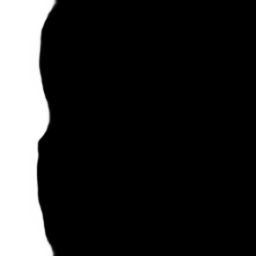

In [55]:
torchvision.transforms.ToPILImage()(h1[0])

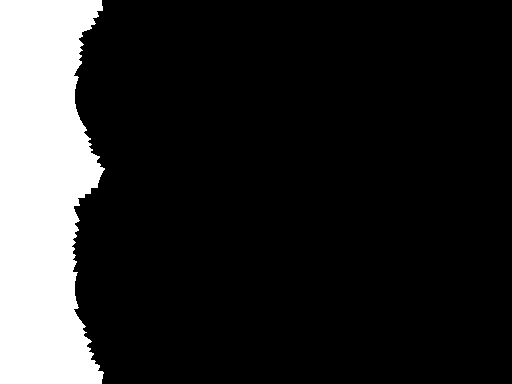

In [49]:
torchvision.transforms.ToPILImage()(y[0])

In [31]:
process_tensor_full(h2, center)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'morphologyEx'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [50]:
def process_tensor_full(tensor, center):
    tensor_np = tensor
    kernel = np.ones((3,3),np.uint8)
    # closing = tensor_np
    closing = cv.morphologyEx(tensor_np, cv.MORPH_ERODE, kernel)
    _, labels = cv.connectedComponents(closing)
    mask = np.isin(labels, labels[:, 0])
    cleaned = np.where(mask, closing, 0)
    # cleaned = closing
    cleaned = cv.morphologyEx(cleaned, cv.MORPH_DILATE, kernel)

    
    
    value = np.sqrt(((cleaned.shape[1]/2.0)**2.0)+((cleaned.shape[0]/2.0)**2.0))
    
    polar_image = cv.linearPolar(cleaned, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
    # polar_image = closing
    kernel = np.ones((10, 10),np.uint8)

    cleaned = cv.morphologyEx(polar_image, cv.MORPH_CLOSE, kernel)
    return cleaned

def process_tensor_basic(tensor, center):
    value = np.sqrt(((tensor.shape[1]/2.0)**2.0)+((tensor.shape[0]/2.0)**2.0))
    
    polar_image = cv.linearPolar(tensor, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
    return polar_image

process_tensor = process_tensor_full

In [17]:
VAL_INTERM_DIR = 'Final-Improv'

def output(model):
    num_batches = len(valid_output_dl)
    model.eval()
    with torch.no_grad():
        # with tqdm(total=num_batches) as pbar:
        #     pbar.set_description("Training Dataset")
        #     for (X, mask, y, filename, center) in train_output_dl:
        #         center = [c.item() for c in center]
        #         h = model(X, mask)
        #         h = h.detach().cpu().numpy()[0,0]
        #         h = to_cart(h, center)
        #         cv.imwrite(os.path.join(TRAIN_INTERM_DIR, filename[0] + '-interm.jpg'), h * 255)
        #         pbar.update(1)
                
        num_batches = len(valid_output_dl)
        dices = []
        with tqdm(total=num_batches) as pbar:
            pbar.set_description("Validation Dataset")
            for (X, mask, y, filename, center) in valid_output_dl:
                center = [c.item() for c in center]
                # h1, h2 = model(X, mask)
                X = X.to(DEVICE)
                h1, h2 = model(X, mask)
                # h2 = model(X, mask)
                H = X.shape[2] // 4
                # h1 = h1[:,:,H:-H,:]
                # h2 = h2[:,:,H:-H,:]
                mask = mask.to(DEVICE)
                # h = (h1 + h2)*mask / 2
                h = h2 # * mask
                # print(h)
                h = h.detach().cpu().numpy()[0,0]
                y_tilde = np.uint8(h > .0)
                y_tilde = process_tensor(y_tilde, center)
                h = process_tensor(np.uint8(h * 255), center)
                y = y.detach().cpu().numpy()[0,0]
                y = np.round(y)
                tp = np.sum(np.minimum(y_tilde, y))
                fp = np.sum(np.minimum(y_tilde, 1 - y))
                fn = np.sum(np.minimum(1 - y_tilde, y))
                tn = np.sum(np.minimum(1 - y_tilde, 1 - y))
                dice = 2 * tp / (2 * tp + fp + fn)
                dices.append(dice)
                img = np.concatenate([y_tilde * 255, y * 255], axis=1)
                # cv.imwrite(os.path.join(VAL_INTERM_DIR, f'{dice:.4f}-' + filename[0] + '.jpg'), img)
                pbar.update(1)
        print(np.mean(np.array(dices)))

In [26]:
# net.pad = True
output(net)

Validation Dataset: 100%|████████████████████████████████████████████████████████████| 259/259 [00:54<00:00,  4.78it/s]

0.8791063990947947
